##### Visualize model outputs at nanoose<br>
G Oldford
Created: Apr 2023

Purpose: Check in NEMO model predicts trends observed at Nanoose station. 
         generate climatological profile and visuals of anom, trends 
         from NEMO SS1500 outputs (v1: ASC clipped to ECOSPACE, v2: full NEMO domain)
         following code from TJ. Do this 'blind' so not all data is used. 
         Also compare performance of RUN203 vs RUN204 (increased vert mixing)
         
Data in: Nanoose obs files prepped for pyap (.nc) and NEMO results extracted to match (.pickle)
         from pyap's 'extract.py' tool. 
         
Data out: climatology and time series (.nc) for Nanoose

Code based on work by Tereza Jarnikova to generate the figs and analysis for temp, salin

last updated: Aug 2 2023

Notes: 
- 2023-04-13 - a little odd but quickest method is to use the pyap 'extract.py' output which does heavy lifting of spatial-temporal interpolation (but it does not interpolate over depths - this is done in analyze.py though). 
- 2023-04-14 - given that CTD depths are nearly all deeper than model min depth of half a metre, we cannot use the interpolation to estimate temp, salin at half a metre. The shallowest is one a half metre, therefore.

In [2]:
import glob
import xarray as xr
import pickle
import os

import cartopy as cp
import matplotlib.pyplot as plt
import numpy as np
import glob

import cartopy
from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import cmocean as cm

import time
import datetime as dt

from scipy import interpolate

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [1]:
# global params

# CTD have rarely got depths as shallow as half metre (i.e. first model level)
# so the interp function returns nans for this level and the resulting CTD
# prepped data has (mostly nans) - do not keep this level in both CTD and model output?
drop_firstlev = True 

## 1) PROCESS NANOOSE OBS SECTION

In [5]:
obs_p = "D:/Sync/For_TJ/nanoose_prepped_2023-02-13/prepped_pyapnames/CTD/"
obs_ctd = glob.glob(obs_p + '*.nc')

# test
test_ctd = obs_ctd[0:20]
obs = xr.open_dataset(test_ctd[0])
obs

<xarray.Dataset>
Dimensions:      (pressure: 264, single: 1)
Dimensions without coordinates: pressure, single
Data variables:
    Pres         (pressure) float32 ...
    temperature  (pressure) float64 ...
    cTemp        (pressure) float64 ...
    salinity     (pressure) float64 ...
    aSal         (pressure) float64 ...
    pDen         (pressure) float64 ...
    time         (single) datetime64[ns] ...
    depth        (single) float32 ...
    latitude     (single) float32 ...
    longitude    (single) float32 ...

In [14]:
plot_obs = False
fact = 0.5
if plot_obs:

    
    fig, axs = plt.subplots(1,1, figsize=(27*fact, 8*fact), facecolor='w', edgecolor='k')

    # with open('./sampleda./ForTereza/prepped_pyapnames/11-03-08_2014h.pickle', 'rb') as pickle_file:
    #     model = pickle.load(pickle_file)
    bad_ctds = []
    for i in range(0, len(obs_ctd)):
        if i%1000 == 0:
            print(i)
        try:
            obs = xr.open_dataset(obs_ctd[i])
            ttime = (obs['time'].values)
            tobs = len(obs['Pres'].values)
            t = np.empty(tobs, dtype='datetime64[s]')
            t[:] = ttime[0]
            w =axs.scatter(t, obs['Pres'].values, c = obs['cTemp'].values, s = 2, vmin = 6, vmax = 12, cmap = cm.cm.thermal)

        except:
            bad_ctds.append(obs_ctd[i])

    plt.colorbar(w, label = 'deg C')
    axs.invert_yaxis()

    fig.savefig('raw_ctd_nanoose.jpg')

In [7]:
# sort CTD by date for processing

ctd_bydate = []
for i in range(0,len(obs_ctd)):
    my_string = obs_ctd[i]
    datestr = (my_string.split("CTD_",1)[1]) #get the stuff after CTD
    ctd_bydate.append(datestr)
    
ctd_bydate.sort()
print('first 10 date substrings from ctd file names,  to check if sorting worked')
print(ctd_bydate[0:10])

first 10 date substrings from ctd file names,  to check if sorting worked
['1969-02-11_1835h.nc', '1969-02-11_2010h.nc', '1969-02-28_1725h.nc', '1969-02-28_2000h.nc', '1969-03-03_1725h.nc', '1969-03-06_1713h.nc', '1969-03-07_1720h.nc', '1969-03-10_0000h.nc', '1969-03-13_1740h.nc', '1969-03-17_1800h.nc']


In [16]:
# get model depths to interpolate to     
# The last three model depth bins are 387.60321045, 414.53408813, 441.46609497.
# Because we've decided to throw out all measurements below 400m, we can only interpolate to model bin 387.60321045

tmodel = xr.open_dataset('D:/Sync/For_TJ/SalishSea1500-RUN203_1h_grid_T_y1990m04_clipped.nc')
mod_depth = tmodel['deptht']

modd_um = np.zeros(40)
for i in range(0,40):

    modd_um[i] = mod_depth[i]
    
modd_um

array([  0.5000003 ,   1.5000031 ,   2.50001144,   3.50003052,
         4.50007057,   5.50015068,   6.50031042,   7.50062323,
         8.50123596,   9.50243282,  10.50476551,  11.50931168,
        12.51816654,  13.53541183,  14.56898212,  15.63428783,
        16.76117325,  18.00713539,  19.48178482,  21.38997841,
        24.10025597,  28.22991562,  34.68575668,  44.51772308,
        58.48433304,  76.58558655,  98.06295776, 121.86651611,
       147.08946228, 173.11448669, 199.57304382, 226.26029968,
       253.06663513, 279.93453979, 306.834198  , 333.75018311,
       360.67453003, 387.60321045, 414.53408813, 441.46609497])

In [9]:
# interpolate t and s to model depths 
# interpolation for every CTD, and save in a pickle array along with the dates

def get_model_interpolated(ncname, verbose = True):

    tobs = xr.open_dataset(ncname)
    obs_d = tobs['Pres'].values
    obs_t = tobs['cTemp'].values
    obs_s = tobs['aSal'].values
    ttime = tobs['time'][0].values
    
    #throw out stuff below 400
    filt = obs_d > 400
    obs_d[filt] = np.nan
    obs_t[filt] = np.nan
    obs_s[filt] = np.nan
    
    try:
        f = interpolate.interp1d(obs_d, obs_t) #temperature
        f2 = interpolate.interp1d(obs_d, obs_s) #salinity

        ## can only interpolate to model points that are within observations 
        mod_d = modd_um[(modd_um<max(obs_d)) & (modd_um>min(obs_d))]
        firstind = np.where(modd_um == np.min(mod_d))[0][0] ## first model index we were able to interpolate to 
        interp_t = f(mod_d)   # use interpolation function returned by `interp1d`
        interp_s = f2(mod_d)

        ### 
        t_full = np.zeros(40)
        t_full[:] = -999
        t_full[firstind:firstind+len(mod_d)] = interp_t
        t_full[t_full < -900] = np.nan

        s_full = np.zeros(40)
        s_full[:] = -999
        s_full[firstind:firstind+len(mod_d)] = interp_s
        s_full[s_full < -900] = np.nan



        if verbose:
            fig, axs =  plt.subplots(1,2)
            axs = axs.ravel()
            axs[0].plot(obs_t, obs_d, 'ob', interp_t, mod_d, 'or')
            axs[1].plot(obs_s, obs_d, 'ob', interp_s, mod_d, 'or')
            axs[0].set_title('temperature cons')
            axs[1].set_title('salinity abs')
            axs[0].invert_yaxis()
            axs[1].invert_yaxis()

            fig.suptitle(f'blue is CTD, red is interp. to mod depths \n date of cast: {ttime}')
            plt.tight_layout()
            plt.show()
    except:
               
        t_full = np.zeros(40)
        t_full[:] = -999
        t_full[t_full < -900] = np.nan
        s_full = np.zeros(40)
        s_full[:] = -999
        s_full[s_full < -900] = np.nan
        
    return t_full, s_full, ttime

#test
#t_full, s_full, ttime  = get_model_interpolated(obs_ctd[300])

extract = False
if extract:
    time_array = np.empty(len(ctd_bydate), dtype='datetime64[s]')
    salt_array = np.zeros([len(ctd_bydate), 40])
    temp_array = np.zeros([len(ctd_bydate), 40])

    for i in range(0,len(ctd_bydate)):
        #print(f'{i}, {ctd_bydate[i]}')
        
        tstr = glob.glob(f'{obs_p}*{ctd_bydate[i]}')[0]
        
        t_full, s_full, ttime  = get_model_interpolated(tstr, verbose = False)

        salt_array[i,:] = s_full
        temp_array[i,:] = t_full
        time_array[i] = ttime
        
    # added by G0 since rarely CTD starts <= 0.5 m
    if drop_firstlev == True:
        salt_array[:,0] = np.nan
        temp_array[:,0] = np.nan           

    pickle.dump(salt_array, open("./climatol_intermediate_files/CTD-salt_array.pkl", 'wb'))
    pickle.dump(temp_array, open("./climatol_intermediate_files/CTD-temp_array.pkl", 'wb'))
    pickle.dump(time_array, open("./climatol_intermediate_files/CTD-time_array.pkl", 'wb'))   
    


(5692, 40)


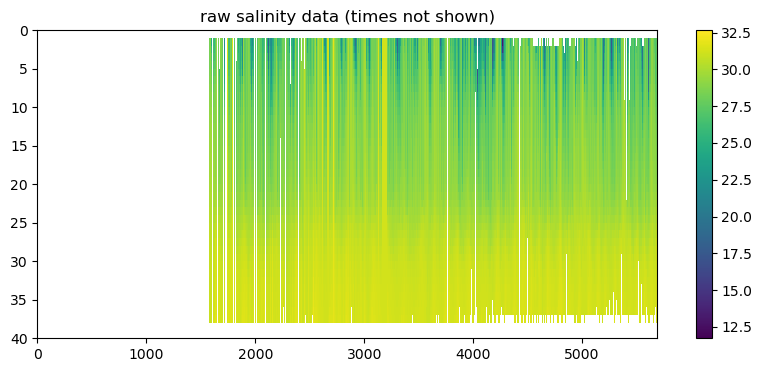

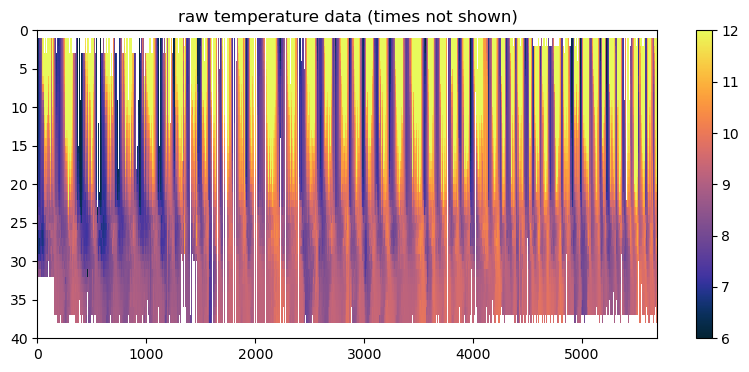

In [3]:
  # open the delicious pickles 
# which contain obs data interpolated
temp_array = pickle.load(open('./climatol_intermediate_files/CTD-temp_array.pkl', 'rb'))
salt_array = pickle.load(open('./climatol_intermediate_files/CTD-salt_array.pkl', 'rb'))
time_array = pickle.load(open('./climatol_intermediate_files/CTD-time_array.pkl', 'rb'))

print(np.shape(salt_array))


fig, axs = plt.subplots(figsize = (10,4))
w = plt.pcolormesh(np.transpose(salt_array))
axs.set_title('raw salinity data (times not shown)')
plt.colorbar(w, ax = axs)
axs.invert_yaxis()

fig, axs = plt.subplots(figsize = (10,4))
w = plt.pcolormesh(np.transpose(temp_array), vmin = 6, vmax = 12, cmap = cm.cm.thermal)
axs.set_title('raw temperature data (times not shown)')
plt.colorbar(w, ax = axs)
axs.invert_yaxis()

14245


C:\Users\Greig\AppData\Local\Temp\ipykernel_16116\2403128481.py:29: RuntimeWarning: Mean of empty slice
  salt_ts[i,:] = np.nanmean(available_salt_toav, axis = 0)
C:\Users\Greig\AppData\Local\Temp\ipykernel_16116\2403128481.py:32: RuntimeWarning: Mean of empty slice
  temp_ts[i,:] = np.nanmean(available_temp_toav, axis = 0)


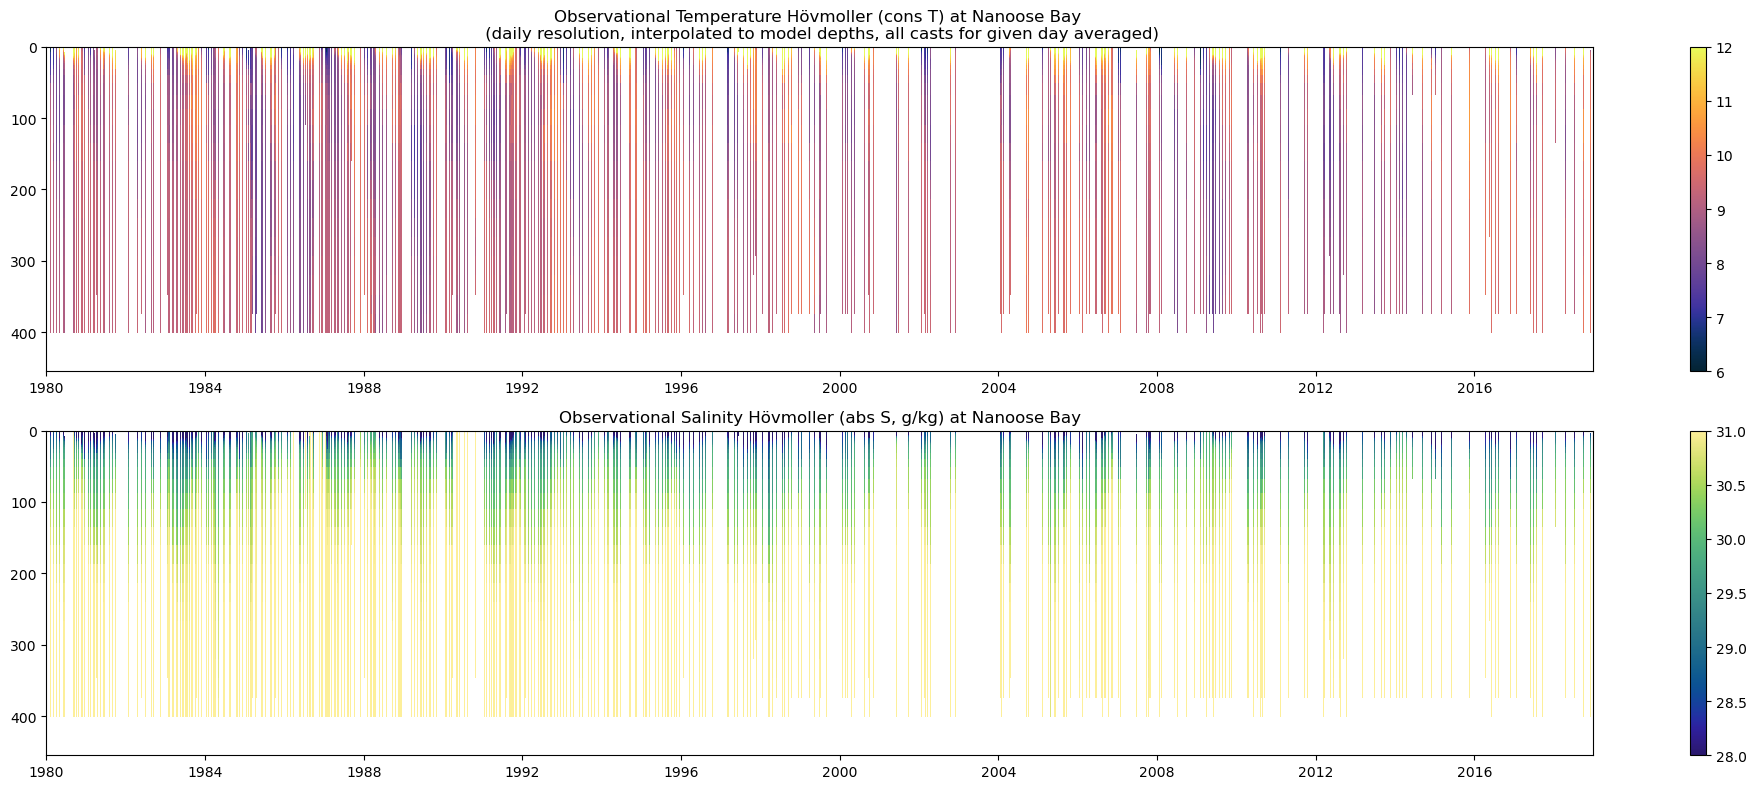

In [17]:
# filter by dates corresponding to model minus spin up year
# and bin into daily blocks

start_date1 = '1980-01-01'
end_date1 = '2018-12-31'

import pandas as pd
dates_obs = pd.DatetimeIndex(time_array)
obs_yrs = dates_obs.year; obs_months = dates_obs.month; obs_days = dates_obs.day

# print(dates[0])
# print(dates[-1])
dates_all = pd.date_range(start=start_date1, end=end_date1, freq='D')
dates_yrs = dates_all.year; dates_months = dates_all.month; dates_days = dates_all.day

print(len(dates_all))
salt_ts = np.zeros([len(dates_all), 40]); salt_ts[:] = np.nan
temp_ts = np.zeros([len(dates_all), 40]); temp_ts[:] = np.nan

### retreive all measurements for a given day. they are given in size [1, x, 40] 
#so you need to take 0 in the first dimension
#not doing so was the error 

for i in range(0, len(dates_all)):
    find_obs = np.where((obs_yrs == dates_yrs[i]) & (obs_months == dates_months[i]) & (obs_days == dates_days[i]))
    if (len(dates_obs[find_obs])>0):
        available_salt = salt_array[find_obs,:]
        available_salt_toav = available_salt[0,:,:]
        salt_ts[i,:] = np.nanmean(available_salt_toav, axis = 0)
        available_temp = temp_array[find_obs,:]
        available_temp_toav = available_temp[0,:,:]
        temp_ts[i,:] = np.nanmean(available_temp_toav, axis = 0)
        

# visualize, include gaps
fig, axs = plt.subplots(2, 1, figsize = (20,8))
axs = axs.ravel()
temp_ts[temp_ts <-900] = np.nan
w = axs[0].pcolormesh(dates_all, modd_um, np.transpose(temp_ts), vmin=6, vmax=12, cmap = cm.cm.thermal)
plt.colorbar(w, ax = axs[0])
#axs[0].set_ylim(0, 4)
axs[0].invert_yaxis()

salt_ts[salt_ts <-900] = np.nan
w = axs[1].pcolormesh(dates_all, modd_um, np.transpose(salt_ts), vmin=28, vmax=31, cmap = cm.cm.haline)
plt.colorbar(w, ax = axs[1])
axs[1].invert_yaxis()
axs[0].set_title('Observational Temperature Hövmoller (cons T) at Nanoose Bay \n (daily resolution, interpolated to model depths, all casts for given day averaged)')
axs[1].set_title('Observational Salinity Hövmoller (abs S, g/kg) at Nanoose Bay')

plt.tight_layout()

In [20]:
def the_timepd(date):
    tpd = -99
    if ((date.month == 1) & (date.day <= 15)): tpd = 1
    if ((date.month == 1) & (date.day > 15)): tpd = 2   
    if ((date.month == 2) & (date.day <= 15)): tpd = 3
    if ((date.month == 2) & (date.day > 15)): tpd = 4
    if ((date.month == 3) & (date.day <= 15)): tpd = 5
    if ((date.month == 3) & (date.day > 15)): tpd = 6
    if ((date.month == 4) & (date.day <= 15)): tpd = 7
    if ((date.month == 4) & (date.day > 15)): tpd = 8   
    if ((date.month == 5) & (date.day <= 15)): tpd = 9
    if ((date.month == 5) & (date.day > 15)): tpd = 10
    if ((date.month == 6) & (date.day <= 15)): tpd = 11
    if ((date.month == 6) & (date.day > 15)): tpd = 12
    if ((date.month == 7) & (date.day <= 15)): tpd = 12+ 1
    if ((date.month == 7) & (date.day > 15)): tpd = 12+ 2   
    if ((date.month == 8) & (date.day <= 15)): tpd = 12+ 3
    if ((date.month == 8) & (date.day > 15)): tpd = 12+ 4
    if ((date.month == 9) & (date.day <= 15)): tpd = 12+ 5
    if ((date.month == 9) & (date.day > 15)): tpd = 12+ 6
    if ((date.month == 10) & (date.day <= 15)): tpd = 12+ 7
    if ((date.month == 10) & (date.day > 15)): tpd = 12+ 8   
    if ((date.month == 11) & (date.day <= 15)): tpd = 12+ 9
    if ((date.month == 11) & (date.day > 15)): tpd = 12+ 10
    if ((date.month == 12) & (date.day <= 15)): tpd = 12+ 11
    if ((date.month == 12) & (date.day > 15)): tpd = 12+ 12    
    
    return tpd

In [13]:
#bin bimonthly (day <= 15 in a given month is the first time-period of that month)


tslen = (np.shape(salt_ts)[0])



timeperiod = np.zeros(tslen).astype(int)
for i in range(0,len(timeperiod)):
    timeperiod[i] = int(the_timepd(dates_all[i]))
    

    
    
    
# format this interpolated-to-model-depths time-series (nans where no data) as an xarray object, save as netcdf
savenam = './climatol_intermediate_files/ctd_ts_timeseries.nc'
data_vars = {
    'salinity':(['time_counter', 'deptht'], salt_ts,
    {'units': 'psu',
    'long_name':'practical salinity'}),
    'temperature':(['time_counter', 'deptht'], temp_ts,
    {'units': 'deg C',
    'long_name':'in situ temperature'}),
    'timeperiod':(['time_counter'], timeperiod,
    {'units': '1-24, first half of jan is 1',
    'long_name':''}),             
    }

# define coordinates
coords = {'time_counter': (['time_counter'], dates_all),
    'deptht': (['deptht'], modd_um)}
# define global attributes
attrs = {'made in':'Visuals-Data - CTD Obs, Mod at Nanoose (Blind).ipynb',
'desc': 'Nanoose Bay Station TS of salt, temp tagged by bimonthly time period, interp to model depths'
}
ds = xr.Dataset(data_vars=data_vars,
coords=coords,
attrs=attrs)
ds.to_netcdf(savenam)

In [5]:
# resample  time-series such that there are 24 time-periods per year (for the purposes of graphing, as well as finding any trends)
# to make a tidy xarray object, assign dates manually, 2 nominal "days" per month, Jan 1- Jan 15 is Jan 7, Jan 16- Jan 31 is Jan 23, etc
#https://pandas.pydata.org/docs/user_guide/timeseries.html#timeseries-offset-aliases
tdt = np.array(((pd.date_range(start='{start_date1}-01-01'.format(start_date1=start_date1), 
                              end='{end_date1}-12-01'.format(end_date1=end_date1), 
                              freq='SM')+ pd.DateOffset(days=-8)).strftime("%Y-%m-%d")), dtype='datetime64') 


Text(0.5, 0.98, 'observational timeseries, grouped into bimonthly (~15day) windows')

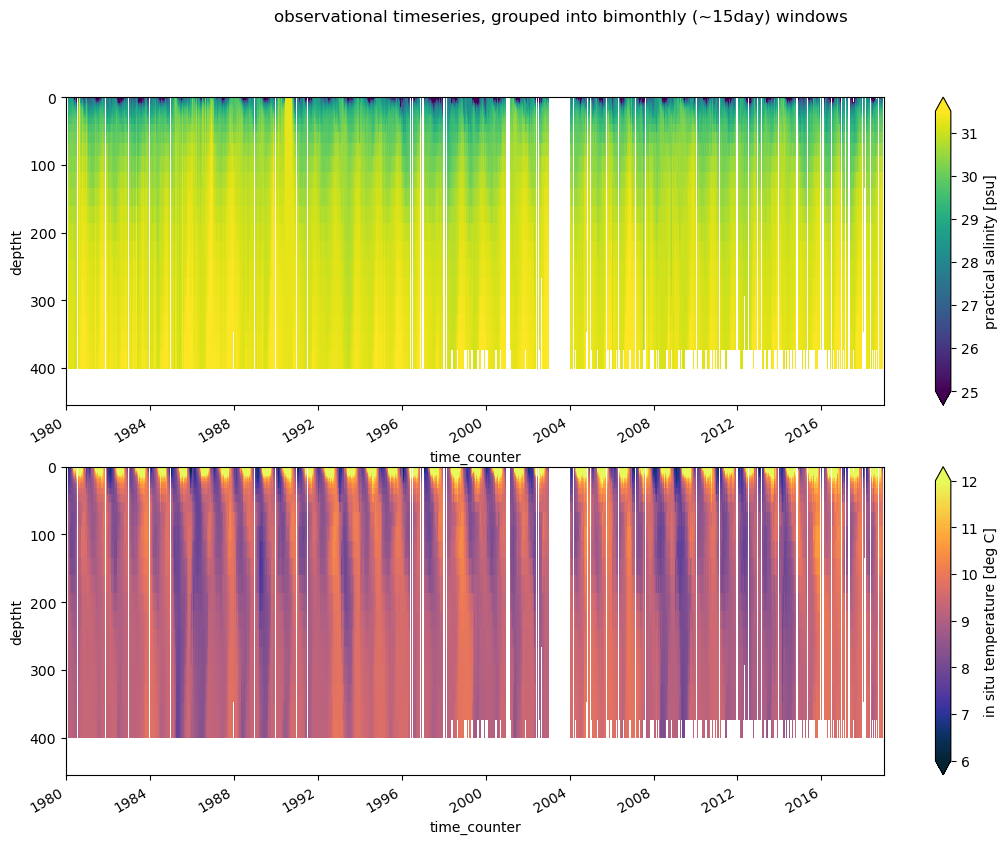

In [7]:
make_bimonthly = False #don't run this analysis if you don't need to
savenam = './climatol_intermediate_files/ctd_ts_timeseries_bimonthly.nc'
if make_bimonthly:
    tperiod = ds.timeperiod.values
    timestamp = ds.time_counter.values
    dates_obs = pd.DatetimeIndex(timestamp)
    obs_yrs = np.array(dates_obs.year)

    salt = ds.salinity.values
    temp = ds.temperature.values

    salt_bimonth = np.zeros([936,40]); salt_bimonth[:] = np.nan
    temp_bimonth = np.zeros([936,40]); temp_bimonth[:] = np.nan
    this_timeperiod = np.zeros([936])

    ind = 0
    for yr in range(1980,2019):
        for tp in range(1,25):
            filt = ((obs_yrs == yr) & (tperiod == tp))
            salt_bimonth[ind,:] = np.nanmean((salt[filt,:]), axis = 0)
            temp_bimonth[ind,:] = np.nanmean((temp[filt,:]), axis = 0)
            this_timeperiod[ind] = tp
            ind = ind+1
    
    data_vars = {
        'salinity':(['time_counter', 'deptht'], salt_bimonth,
        {'units': 'psu',
        'long_name':'practical salinity'}),
        'temperature':(['time_counter', 'deptht'], temp_bimonth,
        {'units': 'deg C',
        'long_name':'in situ temperature'}),
        'timeperiod':(['time_counter'], this_timeperiod,
        {'units': '1-24, first jalf of jan is 1',
        'long_name':''}),             
        }

    # define coordinates
    coords = {'time_counter': (['time_counter'], tdt),
        'deptht': (['deptht'], modd_um)}
    # define global attributes
    attrs = {'made in':'NanooseObs/checkSampleData.ipynb',
    'desc': 'yearly files, saving only variables of interest'
    }
    ds2 = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)
    ds2.to_netcdf(savenam)
    
else:
    ds2 = xr.open_dataset(savenam)
    
# plot the binned TS

fact = 1.1
fig, axs = plt.subplots(2,1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

salt_bm = ds2.salinity.T
xr.plot.pcolormesh(salt_bm, ax = axs[0], vmin = 25, vmax = 31.5)

temp_bm = ds2.temperature.T
xr.plot.pcolormesh(temp_bm, ax = axs[1], cmap = cm.cm.thermal, vmin = 6, vmax = 12)

axs[0].invert_yaxis()
axs[1].invert_yaxis()

plt.suptitle('observational timeseries, grouped into bimonthly (~15day) windows')

In [6]:
export_nc = False
if export_nc:
    salt_bm.to_netcdf('./climatol_intermediate_files/obs_salinity_1980-2018-bimonthly_timeseries.nc')
    temp_bm.to_netcdf('./climatol_intermediate_files/obs_temperature_1980-2018-bimonthly_timeseries.nc')

checkoutput = True
if checkoutput == True:
    salt_bm = xr.open_dataset('./climatol_intermediate_files/obs_salinity_1980-2018-bimonthly_timeseries.nc')
    temp_bm = xr.open_dataset('./climatol_intermediate_files/obs_temperature_1980-2018-bimonthly_timeseries.nc')

In [34]:

export_nc = False
if export_nc:
    salt_clim.to_netcdf('./climatol_intermediate_files/obs_salinity_1980-2018-climatology.nc')
    temp_clim.to_netcdf('./climatol_intermediate_files/obs_temperature_1980-2018-climatology.nc')


checkoutput = True
if checkoutput == True:
    salt_clim = xr.open_dataset('./climatol_intermediate_files/obs_salinity_1980-2018-climatology.nc')
    temp_clim = xr.open_dataset('./climatol_intermediate_files/obs_temperature_1980-2018-climatology.nc')

In [36]:
temp_clim

<xarray.Dataset>
Dimensions:      (deptht: 40, timeperiod: 24)
Coordinates:
  * deptht       (deptht) float64 0.5 1.5 2.5 3.5 ... 360.7 387.6 414.5 441.5
  * timeperiod   (timeperiod) float64 1.0 2.0 3.0 4.0 ... 21.0 22.0 23.0 24.0
Data variables:
    temperature  (deptht, timeperiod) float64 ...

Text(0, 0.5, 'depth (m)')

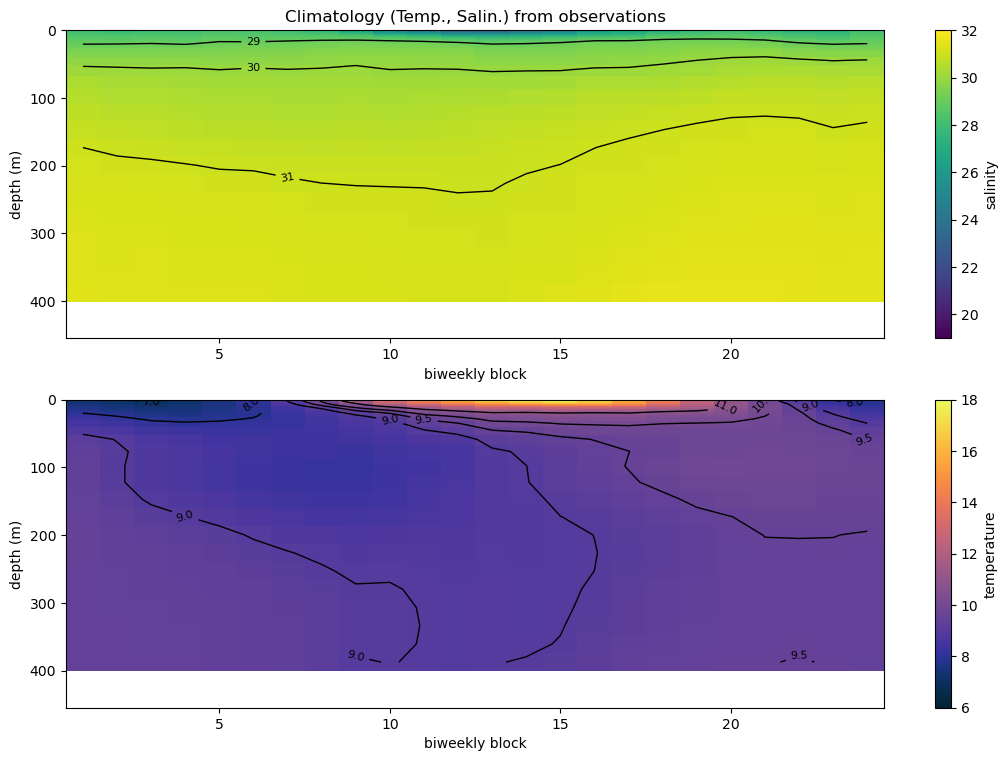

In [37]:
q = ds2.salinity.groupby(ds2.timeperiod).mean().T

obs_salt_clim = salt_clim
obs_temp_clim = temp_clim

fact = 1.1
fig, axs = plt.subplots(2,1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

salt_clim = ds2.salinity.groupby(ds2.timeperiod).mean().T
xr.plot.pcolormesh(salt_clim, ax = axs[0], vmin = 19, vmax = 32)
#xr.plot.pcolormesh(salt_clim, ax = axs[0])

# contours - salt
X,Y = np.meshgrid(salt_clim.timeperiod.values,salt_clim.deptht.values)
# levels = np.linspace(6, 18, 8)
levels=[29,30,31]
cont1 = axs[0].contour(X, Y, salt_clim, levels=levels,colors='black', linestyles='solid', linewidths=1)
axs[0].clabel(cont1, cont1.levels, inline=True, fmt='%.0f', fontsize=8)

temp_clim = ds2.temperature.groupby(ds2.timeperiod).mean().T
xr.plot.pcolormesh(temp_clim, ax = axs[1], cmap = cm.cm.thermal, vmin = 6, vmax = 18)
#xr.plot.pcolormesh(temp_clim, ax = axs[1], cmap = cm.cm.thermal)

# contours - temp
X,Y = np.meshgrid(temp_clim.timeperiod.values,temp_clim.deptht.values)
# levels = np.linspace(6, 18, 8)
levels=[7,8,9,9.5,10,11]
cont2 = axs[1].contour(X, Y, temp_clim, colors='black', levels=levels, linestyles='solid', linewidths=1)
axs[1].clabel(cont2, cont2.levels, inline=True, fmt='%.1f', fontsize=8)

axs[0].invert_yaxis()
axs[1].invert_yaxis()
# axs[1].set_yscale("log")
axs[0].set_title('Climatology (Temp., Salin.) from observations')
axs[0].set_xlabel('biweekly block')
axs[1].set_xlabel('biweekly block')
axs[0].set_ylabel("depth (m)")
axs[1].set_ylabel("depth (m)")

# fig.suptitle('observational climatology of T and S from the Nanoose dataset \n biweekly time-periods')

# 2) PROCESS MODEL DATA AT NANOOSE SECTION
Quickest method is to use the pyap 'extract.py' output which does heavy lifting of spatial-temporal interpolation. given the workflow below we will then need to reverse the interpolation of model outputs back to the model depths

Notes:
- 2023-04-14 - pyap gives us a nice index files but just for my sanity I'm matching TJ's method of globbing and sorting and re-exporting as single pickle files

In [11]:
# Pyap extracts as pickle files from model, each file corresponds to CTD cast or other type of sample
# It does not interpolate over depths to match obs 
mod_run = "RUN203"
mod_p = "D:/temp_nemo/" + mod_run + "_EXTRACT" +  "/CTD/DND_Nanoose_2023/prepped_pyapnames"
out_p = "./climatol_intermediate_files"

mod_run = "RUN216"
mod_p = "D:/temp_nemo/" + mod_run + "_EXTRACT" +  "/DND_Nanoose_2023/prepped_pyapnames"
out_p = "./climatol_intermediate_files"


In [12]:

mod_res = glob.glob(os.path.join(mod_p, '*.pickle'))

# sort CTD by date for processing
modres_bydate = []
for i in range(0,len(mod_res)):
    my_string = mod_res[i]
    datestr = (my_string.split("CTD_",1)[1]) #get the stuff after CTD
    modres_bydate.append(datestr)
    
modres_bydate.sort()
print('first 10 date substrings from mod results file names,  to check if sorting worked')
print(modres_bydate[0:10])

first 10 date substrings from mod results file names,  to check if sorting worked
['1980-01-06_1751h.pickle', '1980-02-08_1756h.pickle', '1980-02-13_1805h.pickle', '1980-02-21_0700h.pickle', '1980-02-25_1836h.pickle', '1980-02-29_1825h.pickle', '1980-03-04_1816h.pickle', '1980-03-05_1814h.pickle', '1980-03-06_1745h.pickle', '1980-03-11_1733h.pickle']


### (Model) Scan, lump, and dump all NEMO results .pickle files

In [13]:
# dump all into one pickle, top 40 model z (depths)
extract = False
if extract:
    mod_time_array = np.empty(len(modres_bydate), dtype='datetime64[s]')
    mod_salt_array = np.zeros([len(modres_bydate), 40])
    mod_temp_array = np.zeros([len(modres_bydate), 40])

    for i in range(0,len(modres_bydate)):
        #print(f'{i}, {modres_bydate[i]}')
        
        modres_f = os.path.join(mod_p, "*" + modres_bydate[i])
        tstr = glob.glob(modres_f)[0]
        
        mod_dat = pickle.load(open(tstr, 'rb'))
        
        mod_salt_array[i,0:len(mod_dat['salinity'])] = mod_dat['salinity']
        mod_temp_array[i,0:len(mod_dat['pTemp'])] = mod_dat['pTemp']
        mod_time_array[i] = mod_dat['time']
        
        mod_temp_array[mod_temp_array==0] = np.nan
        mod_salt_array[mod_salt_array==0] = np.nan
        
    # added by G0 since rarely CTD starts <= 0.5 m
    if drop_firstlev == True:
        mod_salt_array[:,0] = np.nan
        mod_temp_array[:,0] = np.nan
        
    # DROPPING FINAL TWO LEVELS b/c over 400 m depth)
    mod_salt_array[:,38:] = np.nan
    mod_temp_array[:,38:] = np.nan

    pickle.dump(mod_salt_array, open(os.path.join(out_p, "MOD-" + mod_run + "-salt_array.pkl"), 'wb'))
    pickle.dump(mod_temp_array, open(os.path.join(out_p, "MOD-" + mod_run + "-temp_array.pkl"), 'wb'))
    pickle.dump(mod_time_array, open(os.path.join(out_p, "MOD-" + mod_run + "-time_array.pkl"), 'wb'))

### (Model) open the lumped and dumped pickle files

(3942, 40)


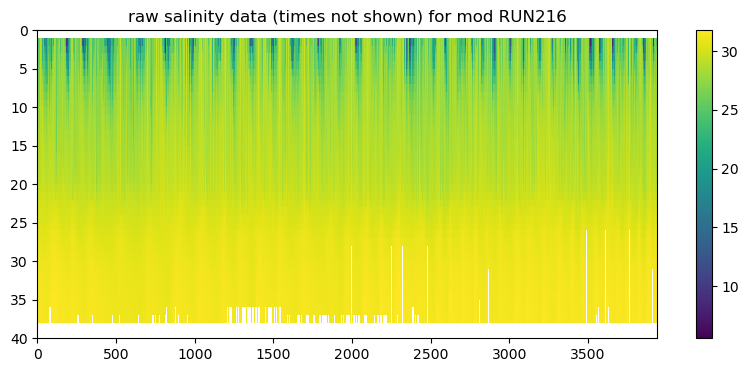

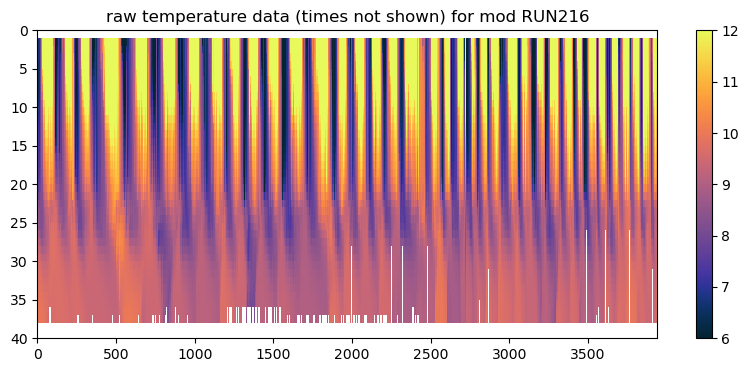

In [14]:
# open the delicious pickles 
# which contain obs data interpolated
mod_temp_array = pickle.load(open(os.path.join(out_p, "MOD-" + mod_run + "-temp_array.pkl"), 'rb'))
mod_salt_array = pickle.load(open(os.path.join(out_p, "MOD-" + mod_run + "-salt_array.pkl"), 'rb'))
mod_time_array = pickle.load(open(os.path.join(out_p, "MOD-" + mod_run + "-time_array.pkl"), 'rb'))

print(np.shape(mod_salt_array))

fig, axs = plt.subplots(figsize = (10,4))
w = plt.pcolormesh(np.transpose(mod_salt_array))
axs.set_title('raw salinity data (times not shown) for mod ' + mod_run)
plt.colorbar(w, ax = axs)
axs.invert_yaxis()

fig, axs = plt.subplots(figsize = (10,4))
w = plt.pcolormesh(np.transpose(mod_temp_array), vmin = 6, vmax = 12, cmap = cm.cm.thermal)
axs.set_title('raw temperature data (times not shown) for mod ' + mod_run)
plt.colorbar(w, ax = axs)
axs.invert_yaxis()

### (Model) binning bi-monthly

14245


C:\Users\Greig\AppData\Local\Temp\ipykernel_16116\3306182726.py:27: RuntimeWarning: Mean of empty slice
  mod_salt_ts[i,:] = np.nanmean(mod_available_salt_toav, axis = 0)
C:\Users\Greig\AppData\Local\Temp\ipykernel_16116\3306182726.py:30: RuntimeWarning: Mean of empty slice
  mod_temp_ts[i,:] = np.nanmean(mod_available_temp_toav, axis = 0)


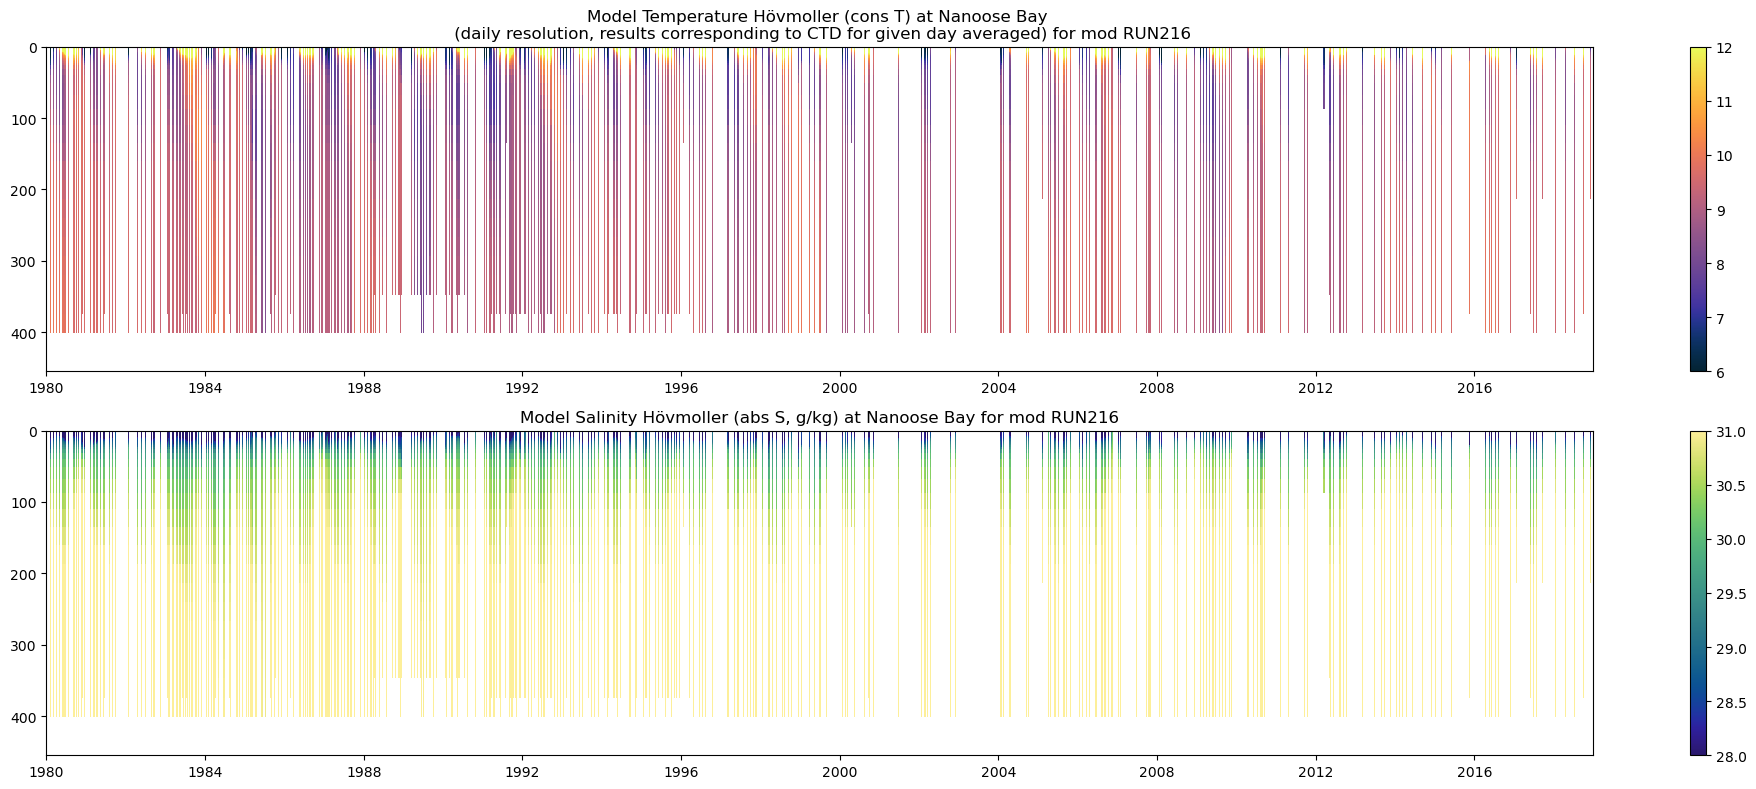

In [18]:
# filter by dates corresponding to model minus spin up year
# and bin into daily blocks

start_date1 = '1980-01-01'
end_date1 = '2018-12-31'

dates_mod = pd.DatetimeIndex(mod_time_array)
mod_yrs = dates_mod.year; mod_months = dates_mod.month; mod_days = dates_mod.day

# print(dates[0])
# print(dates[-1])
dates_all = pd.date_range(start=start_date1, end=end_date1, freq='D')
dates_yrs = dates_all.year; dates_months = dates_all.month; dates_days = dates_all.day

print(len(dates_all))
mod_salt_ts = np.zeros([len(dates_all), 40]); mod_salt_ts[:] = np.nan
mod_temp_ts = np.zeros([len(dates_all), 40]); mod_temp_ts[:] = np.nan

### retreive all model results for a given day. they are given in size [1, x, 40] 
#so you need to take 0 in the first dimension 

for i in range(0, len(dates_all)):
    find_mod = np.where((mod_yrs == dates_yrs[i]) & (mod_months == dates_months[i]) & (mod_days == dates_days[i]))
    if (len(dates_mod[find_mod])>0):
        mod_available_salt = mod_salt_array[find_mod,:]
        mod_available_salt_toav = mod_available_salt[0,:,:]
        mod_salt_ts[i,:] = np.nanmean(mod_available_salt_toav, axis = 0)
        mod_available_temp = mod_temp_array[find_mod,:]
        mod_available_temp_toav = mod_available_temp[0,:,:]
        mod_temp_ts[i,:] = np.nanmean(mod_available_temp_toav, axis = 0)
        

# visualize, include gaps
fig, axs = plt.subplots(2, 1, figsize = (20,8))
axs = axs.ravel()
mod_temp_ts[mod_temp_ts <-900] = np.nan
w = axs[0].pcolormesh(dates_all, modd_um, np.transpose(mod_temp_ts), vmin=6, vmax=12, cmap = cm.cm.thermal)
plt.colorbar(w, ax = axs[0])
#axs[0].set_ylim(0, 4)
axs[0].invert_yaxis()

mod_salt_ts[mod_salt_ts <-900] = np.nan
w = axs[1].pcolormesh(dates_all, modd_um, np.transpose(mod_salt_ts), vmin=28, vmax=31, cmap = cm.cm.haline)
plt.colorbar(w, ax = axs[1])
axs[1].invert_yaxis()
axs[0].set_title('Model Temperature Hövmoller (cons T) at Nanoose Bay \n (daily resolution, results corresponding to CTD for given day averaged) for mod ' + mod_run)
axs[1].set_title('Model Salinity Hövmoller (abs S, g/kg) at Nanoose Bay for mod ' + mod_run)

plt.tight_layout()



### (Model) export the binned bimonthly (two ways)

In [22]:
#bin bimonthly (day <= 15 in a given month is the first time-period of that month)
# and save to .nc for later
export_nc = False
if export_nc:
    tslen = (np.shape(mod_salt_ts)[0])

    timeperiod = np.zeros(tslen).astype(int)
    for i in range(0,len(timeperiod)):
        timeperiod[i] = int(the_timepd(dates_all[i]))

    # save as netcdf
    savenam = './climatol_intermediate_files/MOD_' + mod_run + '_ts_timeseries.nc'
    data_vars = {
        'salinity':(['time_counter', 'deptht'], mod_salt_ts,
        {'units': 'psu',
        'long_name':'practical salinity'}),
        'temperature':(['time_counter', 'deptht'], mod_temp_ts,
        {'units': 'deg C',
        'long_name':'in situ temperature'}),
        'timeperiod':(['time_counter'], timeperiod,
        {'units': '1-24, first half of jan is 1',
        'long_name':''}),             
        }

    coords = {'time_counter': (['time_counter'], dates_all),
        'deptht': (['deptht'], modd_um)}
    attrs = {'made in':'Visuals-Data CTD Obs, Mod for at Nanoose Blind.ipynb by GO Apr 14 2023',
    'desc': 'salt and temp from nemo output for ' + mod_run
    }
    mod_ds = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)
    mod_ds.to_netcdf(savenam)


make_bimonthly = False 
savenam = './climatol_intermediate_files/mod_' + mod_run + '_ts_timeseries_bimonthly.nc'
if make_bimonthly:
    tperiod = mod_ds.timeperiod.values
    timestamp = mod_ds.time_counter.values
    dates_mod = pd.DatetimeIndex(timestamp)
    mod_yrs = np.array(dates_mod.year)

    salt = mod_ds.salinity.values
    temp = mod_ds.temperature.values

    salt_bimonth = np.zeros([936,40]); salt_bimonth[:] = np.nan
    temp_bimonth = np.zeros([936,40]); temp_bimonth[:] = np.nan
    this_timeperiod = np.zeros([936])

    ind = 0
    for yr in range(1980,2019):
        for tp in range(1,25):
            filt = ((mod_yrs == yr) & (tperiod == tp))
            salt_bimonth[ind,:] = np.nanmean((salt[filt,:]), axis = 0)
            temp_bimonth[ind,:] = np.nanmean((temp[filt,:]), axis = 0)
            this_timeperiod[ind] = tp
            ind = ind+1

    data_vars = {
        'salinity':(['time_counter', 'deptht'], salt_bimonth,
        {'units': 'psu',
        'long_name':'practical salinity'}),
        'temperature':(['time_counter', 'deptht'], temp_bimonth,
        {'units': 'deg C',
        'long_name':'in situ temperature'}),
        'timeperiod':(['time_counter'], this_timeperiod,
        {'units': '1-24, first jalf of jan is 1',
        'long_name':''}),             
        }

    # define coordinates
    coords = {'time_counter': (['time_counter'], tdt),
        'deptht': (['deptht'], modd_um)}
    # define global attributes
    attrs = {'made in':'Visuals-Data - CTD Obs, Mod at Nanoose (Blind).pynb by GO Apr 2023',
    'desc': 'salt and temp bimonthly avg from nemo output for ' + mod_run
    }
    mod_ds2 = xr.Dataset(data_vars=data_vars,
                         coords=coords,
                         attrs=attrs)
    mod_ds2.to_netcdf(savenam)
    
else:
    mod_ds2 = xr.open_dataset(savenam)

C:\Users\Greig\AppData\Local\Temp\ipykernel_16116\886958955.py:55: RuntimeWarning: Mean of empty slice
  salt_bimonth[ind,:] = np.nanmean((salt[filt,:]), axis = 0)
C:\Users\Greig\AppData\Local\Temp\ipykernel_16116\886958955.py:56: RuntimeWarning: Mean of empty slice
  temp_bimonth[ind,:] = np.nanmean((temp[filt,:]), axis = 0)


Text(0.5, 0.98, 'model RUN216 timeseries, grouped into bimonthly (~15day) windows')

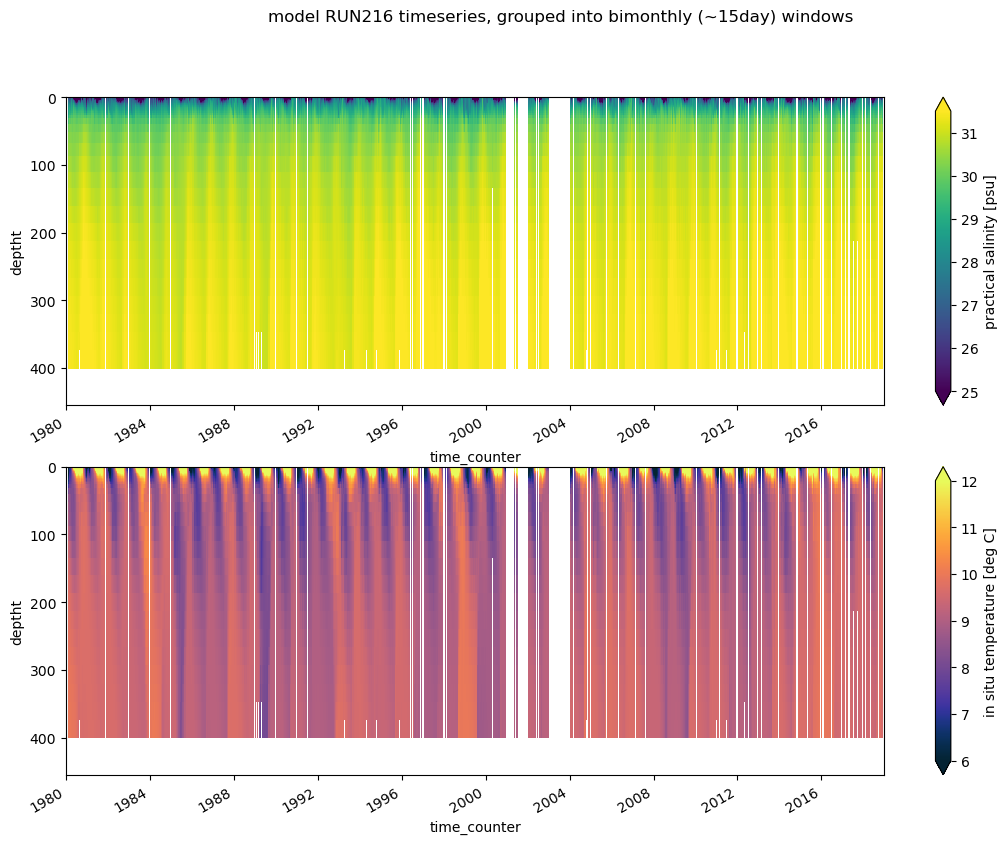

In [45]:
# plot the binned TS

fact = 1.1
fig, axs = plt.subplots(2,1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

mod_salt_bm = mod_ds2.salinity.T
xr.plot.pcolormesh(mod_salt_bm, ax = axs[0], vmin = 25, vmax = 31.5)

mod_temp_bm = mod_ds2.temperature.T
xr.plot.pcolormesh(mod_temp_bm, ax = axs[1], cmap = cm.cm.thermal, vmin = 6, vmax = 12)

axs[0].invert_yaxis()
axs[1].invert_yaxis()

plt.suptitle('model ' + mod_run + ' timeseries, grouped into bimonthly (~15day) windows')

In [24]:
# export as time series
export_nc = False
if export_nc:
    mod_salt_bm.to_netcdf('./climatol_intermediate_files/mod_' + mod_run + 'salinity_1980-2018-bimonthly_timeseries.nc')
    mod_temp_bm.to_netcdf('./climatol_intermediate_files/mod_' + mod_run + 'temperature_1980-2018-bimonthly_timeseries.nc')

checkoutput = True
if checkoutput:
    mod_salt_bm = xr.open_dataset('./climatol_intermediate_files/mod_' + mod_run + 'salinity_1980-2018-bimonthly_timeseries.nc')
    mod_temp_bm = xr.open_dataset('./climatol_intermediate_files/mod_' + mod_run + 'temperature_1980-2018-bimonthly_timeseries.nc')


### (Model) Generate climatologies

In [44]:
mod_salt_clim

<xarray.Dataset>
Dimensions:     (deptht: 40, timeperiod: 24)
Coordinates:
  * deptht      (deptht) float64 0.5 1.5 2.5 3.5 4.5 ... 360.7 387.6 414.5 441.5
  * timeperiod  (timeperiod) float64 1.0 2.0 3.0 4.0 5.0 ... 21.0 22.0 23.0 24.0
Data variables:
    salinity    (deptht, timeperiod) float64 nan nan nan nan ... nan nan nan nan

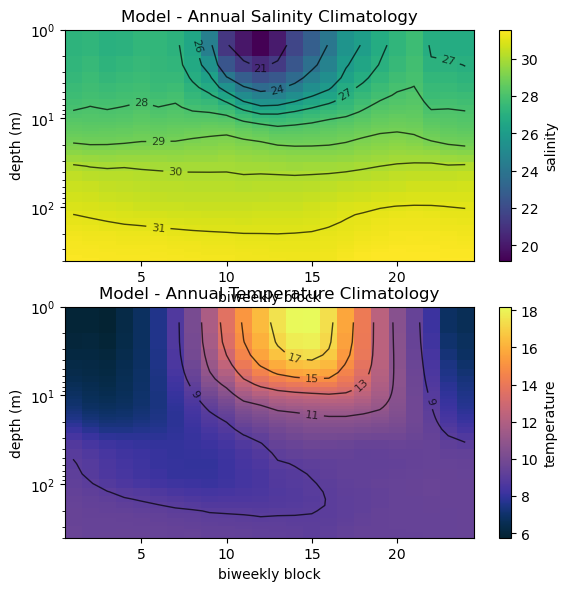

In [26]:

fact = 1.1
fig, axs = plt.subplots(2,1, figsize=(6*fact, 6*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

mod_salt_clim = mod_ds2.salinity.groupby(mod_ds2.timeperiod).mean().T
#xr.plot.pcolormesh(mod_salt_clim, ax = axs[0], vmin = 25, vmax = 31.5)
xr.plot.pcolormesh(mod_salt_clim, ax = axs[0])

mod_temp_clim = mod_ds2.temperature.groupby(mod_ds2.timeperiod).mean().T
#xr.plot.pcolormesh(mod_temp_clim, ax = axs[1], cmap = cm.cm.thermal, vmin = 6, vmax = 12)
xr.plot.pcolormesh(mod_temp_clim, ax = axs[1], cmap = cm.cm.thermal)


axs[0].set_ylim([0.5, 400])
axs[0].set_yscale("log")
axs[0].invert_yaxis()
axs[0].set_ylim([400,1])
# contours - salt
X,Y = np.meshgrid(mod_salt_clim.timeperiod.values,mod_salt_clim.deptht.values)
# levels = np.linspace(6, 18, 8)
levels=[21,24,26,27,28,29,30,31]
cont1 = axs[0].contour(X, Y, mod_salt_clim, levels=levels,colors='black', linestyles='solid', linewidths=1, alpha=0.7)
axs[0].clabel(cont1, cont1.levels, inline=True, fmt='%.0f', fontsize=8)

axs[1].set_ylim([0.5, 400])
axs[1].set_yscale("log")
axs[1].invert_yaxis()
axs[1].set_ylim([400,1])
# contours - temp
X,Y = np.meshgrid(mod_temp_clim.timeperiod.values,mod_temp_clim.deptht.values)
# levels = np.linspace(6, 18, 8)
levels=[9,11,13,15,17,19]
cont2 = axs[1].contour(X, Y, mod_temp_clim, colors='black', levels=levels, linestyles='solid', linewidths=1, alpha=0.7)
axs[1].clabel(cont2, cont2.levels, inline=True, fmt='%.0f', fontsize=8)

axs[0].set_title('Model - Annual Salinity Climatology')
axs[0].set_xlabel('biweekly block')

axs[1].set_title('Model - Annual Temperature Climatology')
axs[1].set_xlabel('biweekly block')
axs[0].set_ylabel("depth (m)")
axs[1].set_ylabel("depth (m)")

mod_s_clim = axs[0]
mod_t_clim = axs[1]

# fig.suptitle('model ' + mod_run + ' climatology of T and S from the Nanoose dataset \n biweekly time-periods')

In [32]:
# export for later
export_nc = False
if export_nc:
    mod_salt_clim.to_netcdf('./climatol_intermediate_files/mod_' + mod_run + '_salinity_1980-2018-climatology.nc')
    mod_temp_clim.to_netcdf('./climatol_intermediate_files/mod_' + mod_run + '_temperature_1980-2018-climatology.nc')

checkoutput = True
if checkoutput:
    mod_salt_clim = xr.open_dataset('./climatol_intermediate_files/mod_' + mod_run + '_salinity_1980-2018-climatology.nc')
    mod_temp_clim = xr.open_dataset('./climatol_intermediate_files/mod_' + mod_run + '_temperature_1980-2018-climatology.nc')


In [33]:
mod_salt_clim

<xarray.Dataset>
Dimensions:     (deptht: 40, timeperiod: 24)
Coordinates:
  * deptht      (deptht) float64 0.5 1.5 2.5 3.5 4.5 ... 360.7 387.6 414.5 441.5
  * timeperiod  (timeperiod) float64 1.0 2.0 3.0 4.0 5.0 ... 21.0 22.0 23.0 24.0
Data variables:
    salinity    (deptht, timeperiod) float64 ...

## Difference the climatologies

In [53]:
q = mod_salt_clim - salt_clim
q.salinity

<xarray.DataArray 'salinity' (deptht: 40, timeperiod: 24)>
array([[            nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan],
       [-8.66872411e-01, -4.18299680e-01, -9.29934218e-01,
        -9.16897583e-01, -9.27408410e-01, -9.40590990e-01,
        -9.31860667e-01, -1.31422842e+00, -2.20572825e+00,
        -3.77101789e+00, -4.21703290e+00, -3.83679289e+00,
        -2.79906255e+00, -1.84365369e+00, -1.64938292e+00,
        -1.91429286e+00, -1.20756145e+00, -1.18856172e+00,
        -1.05925081e+00, -8.26425972e-01, -2.36380170e-01,
        -4.70131003e-01, -6.89294350e-01, -1.25607107e+00],
       [-7.90453441e-01, -4.44625413e-01, -8.59607895e-01,
        -7.10915724e-01, -8.60469635e-01, -9.33849379e-01,
        -8.69377806e-01, -1.27746594e+00, -1.45698662e+00,
        -2.88195343e+00, -3.36361260e+00, -3.03298059e+00,
...
         8.35591378e-02,  1.32305752e-02, -4.00178644e-02,
        -7.44015455e-02, -3.27711161e-02, -8.23771237e-03,
         4.41982782e-02,  5.20891617e-02,  3.39553059e-02,
         6.15869882e-02,  7.84596938e-02,  7.96563482e-02],
       [            nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan],
       [            nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan]])
Coordinates:
  * deptht      (deptht) float64 0.5 1.5 2.5 3.5 4.5 ... 360.7 387.6 414.5 441.5
  * timeperiod  (timeperiod) float64 1.0 2.0 3.0 4.0 5.0 ... 21.0 22.0 23.0 24.0

Text(0.5, 0.98, 'climatology (model - observations), T and S, biweekly time-periods')

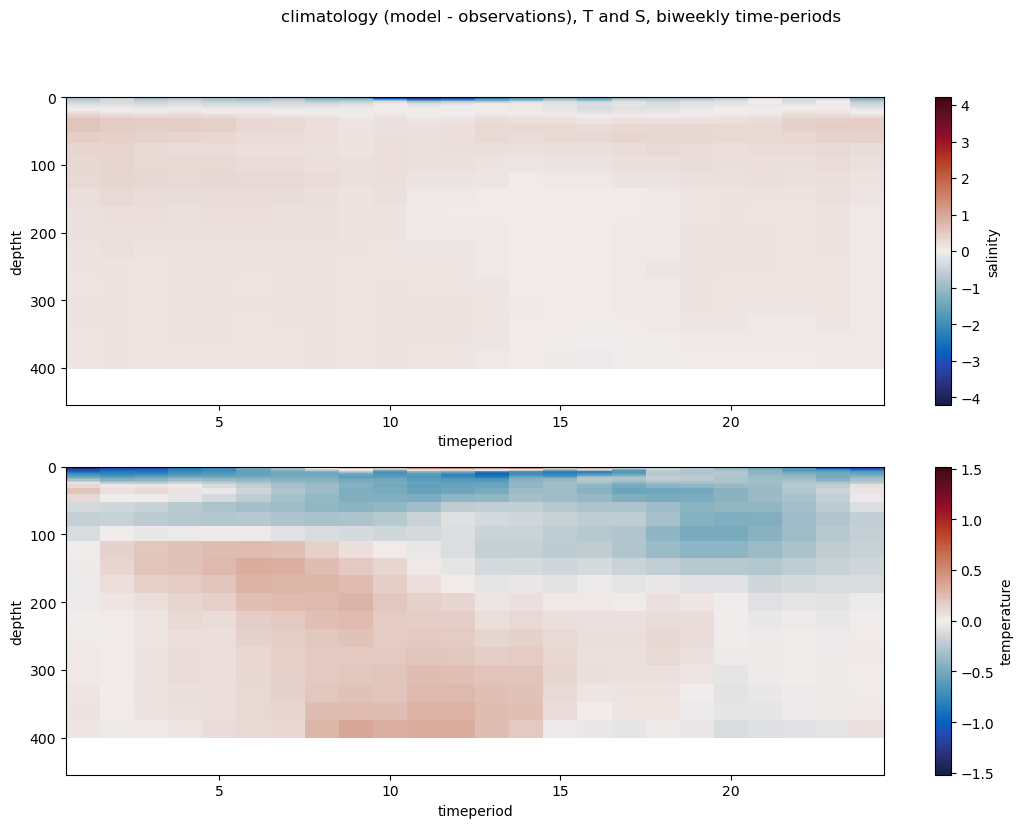

In [55]:
fact = 1.1
fig, axs = plt.subplots(2,1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
xr.plot.pcolormesh((mod_salt_clim - salt_clim).salinity, ax = axs[0], cmap = cm.cm.balance)
xr.plot.pcolormesh((mod_temp_clim - temp_clim).temperature, ax = axs[1], cmap = cm.cm.balance)

axs[0].invert_yaxis()
axs[1].invert_yaxis()

fig.suptitle('climatology (model - observations), T and S, biweekly time-periods')

Text(0.5, 0.98, 'Nanoose Station (model - observations), T and S, biweekly time-periods')

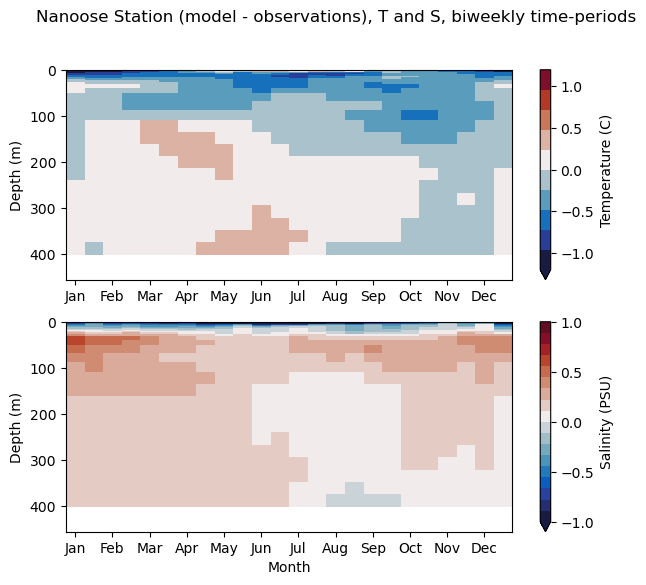

In [59]:
# above with tweaks to colors
q_t = (mod_temp_clim - temp_clim).temperature
q_s = (mod_salt_clim - salt_clim).salinity

from matplotlib.colors import from_levels_and_colors
import matplotlib as mpl

fact = 0.6
fig, axs = plt.subplots(2,1, figsize=(12*fact, 10*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

# temp

# help here: 
# https://stackoverflow.com/questions/48613920/use-of-extend-in-a-pcolormesh-plot-with-discrete-colorbar
# create x boundaries to have x-1 intervals
boundaries = np.arange(-1.25, 1.5, 0.25)
# create list of colors from colormap
cmap_balance = plt.cm.get_cmap('cmo.balance',len(boundaries))
colors = list(cmap_balance(np.arange(len(boundaries))))
#replace first color with white
#colors[0] = "white"
cmap = mpl.colors.ListedColormap(colors[:-1], "")
# set over-color to last color of list 
cmap.set_over(colors[-1])
norm = mpl.colors.BoundaryNorm(boundaries, ncolors=len(boundaries)-1, clip=False)

xr.plot.pcolormesh(q_t, ax = axs[0], cmap = cmap, vmin=-1.2, vmax=1.2, cbar_kwargs={'label':'Temperature (C)'})

#salt
# help here: 
# https://stackoverflow.com/questions/48613920/use-of-extend-in-a-pcolormesh-plot-with-discrete-colorbar
# create x boundaries to have x-1 intervals
boundaries = np.arange(-2.25, 2.5, 0.25)
# create list of colors from colormap
cmap_balance = plt.cm.get_cmap('cmo.balance',len(boundaries))
colors = list(cmap_balance(np.arange(len(boundaries))))
#replace first color with white
#colors[0] = "white"
cmap = mpl.colors.ListedColormap(colors[:-1], "")
# set over-color to last color of list 
cmap.set_over(colors[-1])
#norm = mpl.colors.BoundaryNorm(boundaries, ncolors=len(boundaries)-1, clip=False)
modobs_diff_salt = mod_salt_clim - salt_clim
xr.plot.pcolormesh(q_s, ax = axs[1], cmap = cmap, vmin=-1, vmax=1, cbar_kwargs={'label':'Salinity (PSU)'})

# change to x labels to months
my_xticks_lab = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
axs[0].set_xticks([1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23], my_xticks_lab)
axs[1].set_xticks([1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23], my_xticks_lab)

axs[0].set_ylabel('Depth (m)')
axs[1].set_ylabel('Depth (m)')

axs[0].set_xlabel('')
axs[1].set_xlabel('Month')

axs[0].invert_yaxis()
axs[1].invert_yaxis()

fig.suptitle('Nanoose Station (model - observations), T and S, biweekly time-periods')

### gridspec plot of above

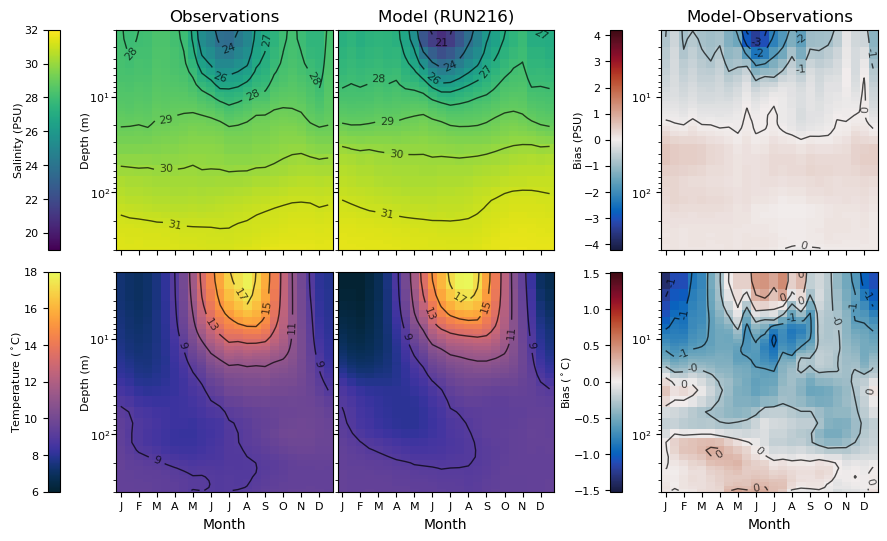

In [64]:
fig_dim_1 = 14
fig_dim_2 = 6
grid_rows = 2
grid_cols = 64
grd_hspace = 0.1
grd_wspace = 0.4
fs_x = 8
fs_y = 8
fs1 = 8

fig = plt.figure(figsize=(fig_dim_1, fig_dim_2))
gs = gridspec.GridSpec(grid_rows, grid_cols,
                       hspace=grd_hspace,
                       wspace=grd_wspace)

ax_tclim_obs = plt.subplot(gs[1:2,5:18]) #bottom left
ax_sclim_obs = plt.subplot(gs[0:1,5:18], sharex=ax_tclim_obs) #top left
ax_tclim_mod = plt.subplot(gs[1:2,18:31],sharey=ax_tclim_obs) # top middle
ax_sclim_mod = plt.subplot(gs[0:1,18:31],sharey=ax_sclim_obs,sharex=ax_tclim_mod) # bottom middle
ax_sdiff = plt.subplot(gs[0:1,37:50],sharey=ax_sclim_obs,sharex=ax_sclim_mod) # top right
ax_tdiff = plt.subplot(gs[1:2,37:50],sharey=ax_tclim_obs,sharex=ax_tclim_mod) # bottom right

# colormeshes
pm_sclim_obs = xr.plot.pcolormesh(obs_salt_clim.salinity, ax = ax_sclim_obs, add_colorbar=False, vmin = 19, vmax = 32)
pm_tclim_obs = xr.plot.pcolormesh(obs_temp_clim.temperature, ax = ax_tclim_obs, add_colorbar=False, cmap = cm.cm.thermal, vmin = 6, vmax = 18)
pm_sclim_mod = xr.plot.pcolormesh(mod_salt_clim.salinity, ax = ax_sclim_mod, add_colorbar=False, vmin = 19, vmax = 32)
pm_tclim_mod = xr.plot.pcolormesh(mod_temp_clim.temperature, ax = ax_tclim_mod, add_colorbar=False, cmap = cm.cm.thermal, vmin = 6, vmax = 18)
pm_sdiff = xr.plot.pcolormesh(q_s, ax = ax_sdiff, add_colorbar=False, cmap = cm.cm.balance)
pm_tdiff = xr.plot.pcolormesh(q_t, ax = ax_tdiff, add_colorbar=False, cmap = cm.cm.balance)

# dummy axes for colorbars
ax_sclim_cb = fig.add_subplot(gs[0:1,1:2])  # Dummy Axes for colorbars
ax_tclim_cb = fig.add_subplot(gs[1:2,1:2])
ax_sdiff_cb = fig.add_subplot(gs[0:1,34:35]) 
ax_tdiff_cb = fig.add_subplot(gs[1:2,34:35]) 

#cbar settings
cb1 = plt.colorbar(pm_sclim_mod, cax=ax_sclim_cb)
cb2 = plt.colorbar(pm_tclim_mod, cax=ax_tclim_cb)
cb3 = plt.colorbar(pm_sdiff, cax=ax_sdiff_cb)
cb4 = plt.colorbar(pm_tdiff, cax=ax_tdiff_cb)
for cb in [cb1, cb2, cb3, cb4]:
    cb.ax.tick_params(labelsize=fs1, left=True, right=False, labelleft=True, labelright=False)
    cb.ax.yaxis.set_label_position("left")
    

cb1.ax.set_ylabel('Salinity (PSU)', fontdict={'fontsize':8}, labelpad=0.1)
cb2.ax.set_ylabel('Temperature ($^\circ$C)', fontdict={'fontsize':8}, labelpad=0.1)
cb3.ax.set_ylabel('Bias (PSU)', fontdict={'fontsize':8}, labelpad=0.1)
cb4.ax.set_ylabel('Bias ($^\circ$C)', fontdict={'fontsize':8}, labelpad=0.1)


# first col
for a in [ax_sclim_obs, ax_tclim_obs]:
    plt.sca(a)
    plt.tick_params(axis='y', labelsize=fs_y, pad=1)
    a.set_ylabel('Depth (m)',fontsize=fs1, labelpad=-1)

# second col
for a in [ax_sclim_mod, ax_tclim_mod]:
    plt.sca(a)
    plt.tick_params(axis='y', labelleft=False)
    plt.ylabel('')

# last col 
for a in [ax_sdiff, ax_tdiff]:
    plt.sca(a)
    plt.tick_params(axis='y', labelleft=True, labelsize=fs_y)
    plt.ylabel('')
# top row
for a in [ax_sclim_obs, ax_sclim_mod, ax_sdiff]:
    plt.sca(a)  
    plt.tick_params(axis='x', labelbottom=False)
    plt.xlabel('')

# bottom row
my_xticks_lab = ['J','F','M','A','M','J','J','A','S','O','N','D']
# axs[0].set_xticks([1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23], my_xticks_lab)
for a in [ax_tclim_obs, ax_tclim_mod, ax_tdiff]:
    plt.sca(a)  
    plt.tick_params(axis='x', labelsize=fs_x)
    a.set_xticks([1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23], my_xticks_lab)
    a.set_xlabel('Month')

#all plots
for a in [ax_sclim_obs, ax_sclim_mod, ax_sdiff, ax_tclim_obs, ax_tclim_mod, ax_tdiff]:
    a.set_ylim([1, 400])
    a.set_yscale("log")
    a.invert_yaxis()
    a.set_ylim([400,2]) # setting to 2 makes the contours better

ax_sclim_obs.set_title('Observations')
ax_sclim_mod.set_title('Model (' + mod_run + ')' )
ax_sdiff.set_title('Model-Observations')

# contours (should combine to one loop)
for s_clim, s_clim_ax in [[obs_salt_clim.salinity,ax_sclim_obs],[mod_salt_clim.salinity,ax_sclim_mod]]:
    X,Y = np.meshgrid(s_clim.timeperiod.values, s_clim.deptht.values)
    levels=[21,24,26,27,28,29,30,31]
    cont1 = s_clim_ax.contour(X, Y, s_clim, levels=levels,colors='black', 
                              linestyles='solid', linewidths=1, alpha=0.7,
                              corner_mask=False
                             )
    s_clim_ax.clabel(cont1, cont1.levels, inline=True, fmt='%.0f', fontsize=8)    

for t_clim, t_clim_ax in [[obs_temp_clim.temperature,ax_tclim_obs],[mod_temp_clim.temperature,ax_tclim_mod]]:
    X,Y = np.meshgrid(t_clim.timeperiod.values, t_clim.deptht.values)
    levels=[9,11,13,15,17,19]
    cont1 = t_clim_ax.contour(X, Y, t_clim, levels=levels,colors='black', 
                              linestyles='solid', linewidths=1, alpha=0.7,
                              corner_mask=False
                             )
    t_clim_ax.clabel(cont1, cont1.levels, inline=True, fmt='%.0f', fontsize=8)

for diff, diff_ax in [[q_s, ax_sdiff],
                      [q_t, ax_tdiff]
                     ]:
    X,Y = np.meshgrid(diff.timeperiod.values, diff.deptht.values)
#     levels=[9,11,13,15,17,19]
    cont1 = diff_ax.contour(X, Y, diff,colors='black', 
                              linestyles='solid', linewidths=1, alpha=0.7,
                              corner_mask=False
                             )
    diff_ax.clabel(cont1, cont1.levels, inline=True, fmt='%.0f', fontsize=8)  

    
    
# axs[0].set_ylim([0.5, 400])
# axs[0].set_yscale("log")
# axs[0].invert_yaxis()
# axs[0].set_ylim([400,1])
# # contours - salt
# X,Y = np.meshgrid(mod_salt_clim.timeperiod.values,mod_salt_clim.deptht.values)
# # levels = np.linspace(6, 18, 8)
# levels=[21,24,26,27,28,29,30,31]
# cont1 = axs[0].contour(X, Y, mod_salt_clim, levels=levels,colors='black', linestyles='solid', linewidths=1, alpha=0.7)
# axs[0].clabel(cont1, cont1.levels, inline=True, fmt='%.0f', fontsize=8)

# plt.sca(ax_sclim_obs)
# plt.tick_params(axis='x', labelsize=fs_x)
    

# fig.colorbar(mesh_2, ax=ax_2)

#                 axt = plt.subplot(gs[0:5,2:4],sharey=axt_mean)
#                 axs_mean = plt.subplot(gs[0:5,4:6], sharey=axt_mean)
#                 axs = plt.subplot(gs[0:5,6:8], sharey=axt_mean)
                
#                 ax = [axt_mean, axt, axs_mean, axs]   
                
#                 # plot the mean temps
#                 ax[0].set_ylabel('Pressure (dBar)', fontsize=fs1)
#                 dep_n = len(plotT_mean['dep'])
#                 obs_t_mean = plotT_mean['mean_obs'][0:dep_n]
#                 ax[0].plot(obs_t_mean, plotT_mean['dep'], 'k-')
#                 obs_t_mean = plotT_mean['mean_mod'][0:dep_n]
#                 ax[0].plot(obs_t_mean, plotT_mean['dep'], 'k--')
#                 ax[0].set_xlabel("Mean\nTemp. ($^\circ$C)", fontsize=fs1)

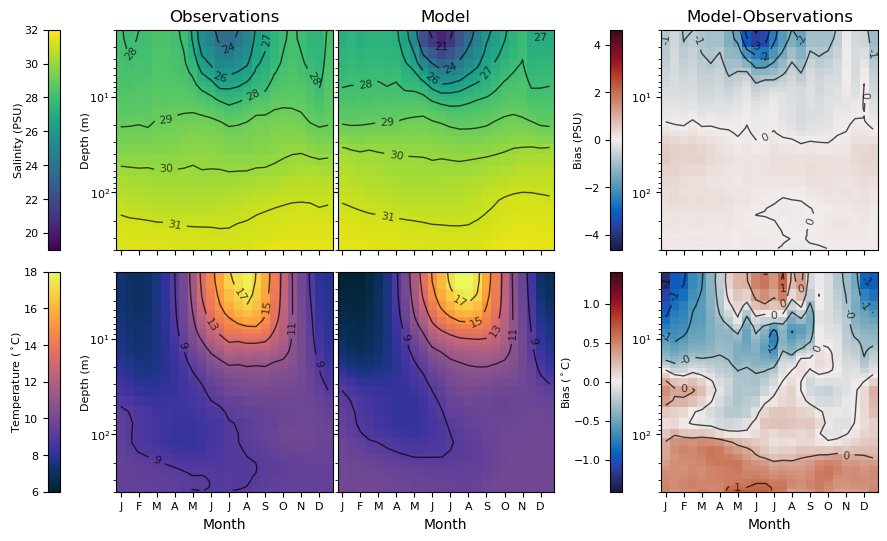

In [313]:
fig_dim_1 = 14
fig_dim_2 = 6
grid_rows = 2
grid_cols = 64
grd_hspace = 0.1
grd_wspace = 0.4
fs_x = 8
fs_y = 8
fs1 = 8

fig = plt.figure(figsize=(fig_dim_1, fig_dim_2))
gs = gridspec.GridSpec(grid_rows, grid_cols,
                       hspace=grd_hspace,
                       wspace=grd_wspace)

ax_tclim_obs = plt.subplot(gs[1:2,5:18]) #bottom left
ax_sclim_obs = plt.subplot(gs[0:1,5:18], sharex=ax_tclim_obs) #top left
ax_tclim_mod = plt.subplot(gs[1:2,18:31],sharey=ax_tclim_obs) # top middle
ax_sclim_mod = plt.subplot(gs[0:1,18:31],sharey=ax_sclim_obs,sharex=ax_tclim_mod) # bottom middle
ax_sdiff = plt.subplot(gs[0:1,37:50],sharey=ax_sclim_obs,sharex=ax_sclim_mod) # top right
ax_tdiff = plt.subplot(gs[1:2,37:50],sharey=ax_tclim_obs,sharex=ax_tclim_mod) # bottom right

# colormeshes
pm_sclim_obs = xr.plot.pcolormesh(obs_salt_clim, ax = ax_sclim_obs, add_colorbar=False, vmin = 19, vmax = 32)
pm_tclim_obs = xr.plot.pcolormesh(obs_temp_clim, ax = ax_tclim_obs, add_colorbar=False, cmap = cm.cm.thermal, vmin = 6, vmax = 18)
pm_sclim_mod = xr.plot.pcolormesh(mod_salt_clim, ax = ax_sclim_mod, add_colorbar=False, vmin = 19, vmax = 32)
pm_tclim_mod = xr.plot.pcolormesh(mod_temp_clim, ax = ax_tclim_mod, add_colorbar=False, cmap = cm.cm.thermal, vmin = 6, vmax = 18)
pm_sdiff = xr.plot.pcolormesh(mod_salt_clim - obs_salt_clim, ax = ax_sdiff, add_colorbar=False, cmap = cm.cm.balance)
pm_tdiff = xr.plot.pcolormesh(mod_temp_clim - obs_temp_clim, ax = ax_tdiff, add_colorbar=False, cmap = cm.cm.balance)

# dummy axes for colorbars
ax_sclim_cb = fig.add_subplot(gs[0:1,1:2])  # Dummy Axes for colorbars
ax_tclim_cb = fig.add_subplot(gs[1:2,1:2])
ax_sdiff_cb = fig.add_subplot(gs[0:1,34:35]) 
ax_tdiff_cb = fig.add_subplot(gs[1:2,34:35]) 

#cbar settings
cb1 = plt.colorbar(pm_sclim_mod, cax=ax_sclim_cb)
cb2 = plt.colorbar(pm_tclim_mod, cax=ax_tclim_cb)
cb3 = plt.colorbar(pm_sdiff, cax=ax_sdiff_cb)
cb4 = plt.colorbar(pm_tdiff, cax=ax_tdiff_cb)
for cb in [cb1, cb2, cb3, cb4]:
    cb.ax.tick_params(labelsize=fs1, left=True, right=False, labelleft=True, labelright=False)
    cb.ax.yaxis.set_label_position("left")
    

cb1.ax.set_ylabel('Salinity (PSU)', fontdict={'fontsize':8}, labelpad=0.1)
cb2.ax.set_ylabel('Temperature ($^\circ$C)', fontdict={'fontsize':8}, labelpad=0.1)
cb3.ax.set_ylabel('Bias (PSU)', fontdict={'fontsize':8}, labelpad=0.1)
cb4.ax.set_ylabel('Bias ($^\circ$C)', fontdict={'fontsize':8}, labelpad=0.1)


# first col
for a in [ax_sclim_obs, ax_tclim_obs]:
    plt.sca(a)
    plt.tick_params(axis='y', labelsize=fs_y, pad=1)
    a.set_ylabel('Depth (m)',fontsize=fs1, labelpad=-1)

# second col
for a in [ax_sclim_mod, ax_tclim_mod]:
    plt.sca(a)
    plt.tick_params(axis='y', labelleft=False)
    plt.ylabel('')

# last col 
for a in [ax_sdiff, ax_tdiff]:
    plt.sca(a)
    plt.tick_params(axis='y', labelleft=True, labelsize=fs_y)
    plt.ylabel('')
# top row
for a in [ax_sclim_obs, ax_sclim_mod, ax_sdiff]:
    plt.sca(a)  
    plt.tick_params(axis='x', labelbottom=False)
    plt.xlabel('')

# bottom row
my_xticks_lab = ['J','F','M','A','M','J','J','A','S','O','N','D']
# axs[0].set_xticks([1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23], my_xticks_lab)
for a in [ax_tclim_obs, ax_tclim_mod, ax_tdiff]:
    plt.sca(a)  
    plt.tick_params(axis='x', labelsize=fs_x)
    a.set_xticks([1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23], my_xticks_lab)
    a.set_xlabel('Month')

#all plots
for a in [ax_sclim_obs, ax_sclim_mod, ax_sdiff, ax_tclim_obs, ax_tclim_mod, ax_tdiff]:
    a.set_ylim([1, 400])
    a.set_yscale("log")
    a.invert_yaxis()
    a.set_ylim([400,2]) # setting to 2 makes the contours better

ax_sclim_obs.set_title('Observations')
ax_sclim_mod.set_title('Model')
ax_sdiff.set_title('Model-Observations')

# contours (should combine to one loop)
for s_clim, s_clim_ax in [[obs_salt_clim,ax_sclim_obs],[mod_salt_clim,ax_sclim_mod]]:
    X,Y = np.meshgrid(s_clim.timeperiod.values, s_clim.deptht.values)
    levels=[21,24,26,27,28,29,30,31]
    cont1 = s_clim_ax.contour(X, Y, s_clim, levels=levels,colors='black', 
                              linestyles='solid', linewidths=1, alpha=0.7,
                              corner_mask=False
                             )
    s_clim_ax.clabel(cont1, cont1.levels, inline=True, fmt='%.0f', fontsize=8)    

for t_clim, t_clim_ax in [[obs_temp_clim,ax_tclim_obs],[mod_temp_clim,ax_tclim_mod]]:
    X,Y = np.meshgrid(t_clim.timeperiod.values, t_clim.deptht.values)
    levels=[9,11,13,15,17,19]
    cont1 = t_clim_ax.contour(X, Y, t_clim, levels=levels,colors='black', 
                              linestyles='solid', linewidths=1, alpha=0.7,
                              corner_mask=False
                             )
    t_clim_ax.clabel(cont1, cont1.levels, inline=True, fmt='%.0f', fontsize=8)

for diff, diff_ax in [[mod_salt_clim - obs_salt_clim, ax_sdiff],
                      [mod_temp_clim - obs_temp_clim, ax_tdiff]
                     ]:
    X,Y = np.meshgrid(diff.timeperiod.values, diff.deptht.values)
#     levels=[9,11,13,15,17,19]
    cont1 = diff_ax.contour(X, Y, diff,colors='black', 
                              linestyles='solid', linewidths=1, alpha=0.7,
                              corner_mask=False
                             )
    diff_ax.clabel(cont1, cont1.levels, inline=True, fmt='%.0f', fontsize=8)  
    
# axs[0].set_ylim([0.5, 400])
# axs[0].set_yscale("log")
# axs[0].invert_yaxis()
# axs[0].set_ylim([400,1])
# # contours - salt
# X,Y = np.meshgrid(mod_salt_clim.timeperiod.values,mod_salt_clim.deptht.values)
# # levels = np.linspace(6, 18, 8)
# levels=[21,24,26,27,28,29,30,31]
# cont1 = axs[0].contour(X, Y, mod_salt_clim, levels=levels,colors='black', linestyles='solid', linewidths=1, alpha=0.7)
# axs[0].clabel(cont1, cont1.levels, inline=True, fmt='%.0f', fontsize=8)

# plt.sca(ax_sclim_obs)
# plt.tick_params(axis='x', labelsize=fs_x)
    

# fig.colorbar(mesh_2, ax=ax_2)

#                 axt = plt.subplot(gs[0:5,2:4],sharey=axt_mean)
#                 axs_mean = plt.subplot(gs[0:5,4:6], sharey=axt_mean)
#                 axs = plt.subplot(gs[0:5,6:8], sharey=axt_mean)
                
#                 ax = [axt_mean, axt, axs_mean, axs]   
                
#                 # plot the mean temps
#                 ax[0].set_ylabel('Pressure (dBar)', fontsize=fs1)
#                 dep_n = len(plotT_mean['dep'])
#                 obs_t_mean = plotT_mean['mean_obs'][0:dep_n]
#                 ax[0].plot(obs_t_mean, plotT_mean['dep'], 'k-')
#                 obs_t_mean = plotT_mean['mean_mod'][0:dep_n]
#                 ax[0].plot(obs_t_mean, plotT_mean['dep'], 'k--')
#                 ax[0].set_xlabel("Mean\nTemp. ($^\circ$C)", fontsize=fs1)

In [292]:
ax_sclim_obs

<AxesSubplot:>

### Linear regression of anomaly trend
#### this is updated in a different notebook

In [47]:
obs_saltts_minusclim = salt_bm.groupby(ds2.timeperiod)-salt_clim
obs_tempts_minusclim = temp_bm.groupby(ds2.timeperiod)-temp_clim
mod_saltts_minusclim = mod_salt_bm.groupby(ds2.timeperiod)-mod_salt_clim
mod_tempts_minusclim = mod_temp_bm.groupby(ds2.timeperiod)-mod_temp_clim

obs_saltts_minusclim.to_netcdf(os.path.join('./climatol_intermediate_files/',mod_run + 'obs_anom_salt_1980-2018.nc'))
obs_tempts_minusclim.to_netcdf(os.path.join('./climatol_intermediate_files/',mod_run + 'obs_anom_temp_1980-2018.nc'))
mod_saltts_minusclim.to_netcdf(os.path.join('./climatol_intermediate_files/',mod_run + 'mod_anom_salt_1980-2018.nc'))
mod_tempts_minusclim.to_netcdf(os.path.join('./climatol_intermediate_files/',mod_run + 'mod_anom_temp_1980-2018.nc'))

# mod_salt_clim.to_netcdf('./climatol_intermediate_files/mod_' + mod_run + '_salinity_1980-2018-climatology.nc')
# mod_temp_clim.to_netcdf('./climatol_intermediate_files/mod_' + mod_run + '_temperature_1980-2018-climatology.nc')

checkoutput = True
if checkoutput == True:
    obs_saltts_minusclim = xr.open_dataset(os.path.join('./climatol_intermediate_files/',mod_run + 'obs_anom_salt_1980-2018.nc'))
    obs_tempts_minusclim = xr.open_dataset(os.path.join('./climatol_intermediate_files/',mod_run + 'obs_anom_temp_1980-2018.nc'))
    mod_saltts_minusclim = xr.open_dataset(os.path.join('./climatol_intermediate_files/',mod_run + 'mod_anom_salt_1980-2018.nc'))
    mod_tempts_minusclim = xr.open_dataset(os.path.join('./climatol_intermediate_files/',mod_run + 'mod_anom_temp_1980-2018.nc'))    
    
    

In [48]:
obs_saltts_minusclim

<xarray.Dataset>
Dimensions:       (time_counter: 936, deptht: 40)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1980-01-07 ... 2018-12-23
  * deptht        (deptht) float64 0.5 1.5 2.5 3.5 ... 360.7 387.6 414.5 441.5
    timeperiod    (time_counter) float64 ...
Data variables:
    salinity      (deptht, time_counter) float64 ...

In [26]:
obs_gt4mtemp['temperature'].values

array([ 0.29159981,         nan, -0.15172305, -0.36814908, -0.23247033,
       -0.29731067, -0.30691426, -0.30686465, -0.12293238, -0.32787798,
       -0.90695116, -0.3997443 , -0.42347066,         nan, -0.57959392,
       -0.26881057, -0.37568767, -0.30600087, -0.20871523,  0.01065514,
        0.00658603, -0.01599535,  0.30490918, -0.3114317 ,  0.31958021,
        0.34364881,  0.25672051,  0.3828332 ,  0.34092361,  0.43702446,
        0.3283901 ,  0.06301188,  0.19396951,  0.07502116, -0.31838769,
       -0.32205125, -0.4928681 , -0.08368024, -0.35357474, -0.38286451,
       -0.02478419, -0.3216677 , -0.3214537 ,  0.02259719,  0.09893826,
               nan,  0.59246481, -0.53463953, -0.25504711, -0.27818139,
       -0.22343298, -0.49362762, -0.27583929, -0.20042232, -0.30934349,
       -0.33563644, -0.11994875, -0.25586578, -0.24706357, -0.14670244,
       -0.27436304, -0.18122487, -0.51192185, -0.35109416, -0.63962096,
       -0.16350721, -0.54721062, -0.29442439, -0.22241469, -0.12

Text(0.5, 0.98, 'Secular Temperature Trend \n (4.5 - 400 m avg)\n')

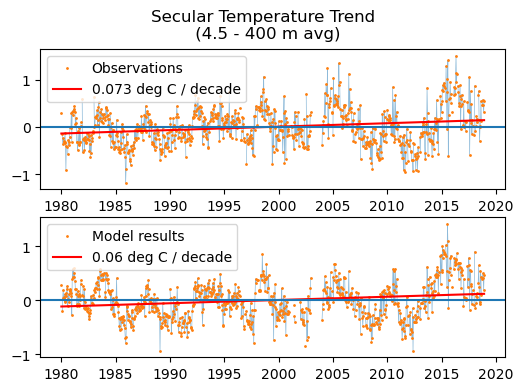

In [28]:
fig, axs = plt.subplots(2,1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

obs_gt4mtemp = obs_tempts_minusclim.isel(deptht = obs_tempts_minusclim.deptht >4).mean(dim = 'deptht')
mod_gt4mtemp = mod_tempts_minusclim.isel(deptht = mod_tempts_minusclim.deptht >4).mean(dim = 'deptht')

# this line needed if checkoutput is True and data re loaded from nc files abve
obs_gt4mtemp = obs_gt4mtemp['temperature']
mod_gt4mtemp = mod_gt4mtemp['temperature']

# top10mtemp.plot(ax = axs[0], color = 'k', linewidth = 0.5, alpha = 0.5)
# axs[0].axhline(y=0)
tyr = np.arange(1980,2019,(1/24))
axs[0].plot(tyr,obs_gt4mtemp.values,linewidth = 0.5, alpha = 0.5)

x = tyr[~np.isnan(obs_gt4mtemp.values)]
y = obs_gt4mtemp.values[~np.isnan(obs_gt4mtemp.values)]

A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, y, rcond=None)[0]
axs[0].plot(x, y, '.', label='Observations', markersize=2)
axs[0].plot(x, m*x + c, 'r', label=f'{round(m*10,3)} deg C / decade')
axs[0].legend(loc = 'best')
axs[0].axhline(y=0)


axs[1].plot(tyr,mod_gt4mtemp.values,linewidth = 0.5, alpha = 0.5)

x = tyr[~np.isnan(mod_gt4mtemp.values)]
y = mod_gt4mtemp.values[~np.isnan(mod_gt4mtemp.values)]

A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, y, rcond=None)[0]
axs[1].plot(x, y, '.', label='Model results', markersize=2)
axs[1].plot(x, m*x + c, 'r', label=f'{round(m*10,3)} deg C / decade')
axs[1].legend(loc = 'best')
axs[1].axhline(y=0)

plt.suptitle('Secular Temperature Trend \n (4.5 - 400 m avg)\n')

Text(0.5, 0.98, 'Nanoose Bay obs. temperatures, top 10 m of watercolumn, bimonthly sampled  \n (climatological seasonal cycle removed)')

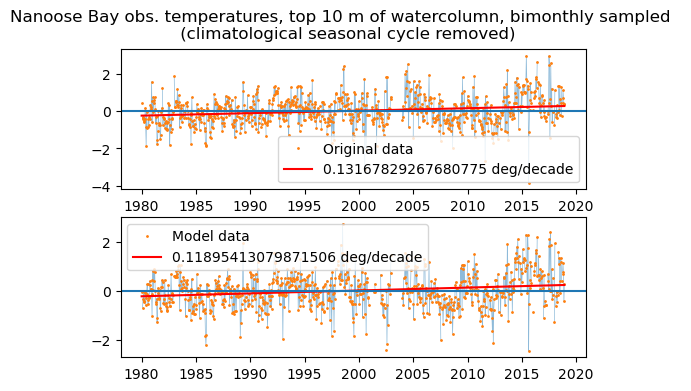

In [29]:
fig, axs = plt.subplots(2,1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

obs_top10mtemp = obs_tempts_minusclim.isel(deptht = obs_tempts_minusclim.deptht <10.5).mean(dim = 'deptht')
mod_top10mtemp = mod_tempts_minusclim.isel(deptht = mod_tempts_minusclim.deptht <10.5).mean(dim = 'deptht')

# this line needed if checkoutput is True and data re loaded from nc files abve
obs_top10mtemp = obs_top10mtemp['temperature']
mod_top10mtemp = mod_top10mtemp['temperature']

# top10mtemp.plot(ax = axs[0], color = 'k', linewidth = 0.5, alpha = 0.5)
# axs[0].axhline(y=0)
tyr = np.arange(1980,2019,(1/24))
axs[0].plot(tyr,obs_top10mtemp.values,linewidth = 0.5, alpha = 0.5)

x = tyr[~np.isnan(obs_top10mtemp.values)]
y = obs_top10mtemp.values[~np.isnan(obs_top10mtemp.values)]
A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, y, rcond=None)[0]
axs[0].plot(x, y, '.', label='Original data', markersize=2)
axs[0].plot(x, m*x + c, 'r', label=f'{m*10} deg/decade')
axs[0].legend(loc = 'best')
axs[0].axhline(y=0)


axs[1].plot(tyr,mod_top10mtemp.values,linewidth = 0.5, alpha = 0.5)

x = tyr[~np.isnan(mod_top10mtemp.values)]
y = mod_top10mtemp.values[~np.isnan(mod_top10mtemp.values)]
A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, y, rcond=None)[0]
axs[1].plot(x, y, '.', label='Model data', markersize=2)
axs[1].plot(x, m*x + c, 'r', label=f'{m*10} deg/decade')
axs[1].legend(loc = 'best')
axs[1].axhline(y=0)

plt.suptitle('Nanoose Bay obs. temperatures, top 10 m of watercolumn, bimonthly sampled  \n (climatological seasonal cycle removed)')

### Check obs trend back to beginning of TS

In [ ]:
# filter by dates corresponding to model minus spin up year
# and bin into daily blocks

# start_date1 = '1970-01-01'
# end_date1 = '2018-12-31'

# import pandas as pd
# dates_obs = pd.DatetimeIndex(time_array)
# obs_yrs = dates_obs.year; obs_months = dates_obs.month; obs_days = dates_obs.day

# # print(dates[0])
# # print(dates[-1])
# dates_all = pd.date_range(start=start_date1, end=end_date1, freq='D')
# dates_yrs = dates_all.year; dates_months = dates_all.month; dates_days = dates_all.day

# print(len(dates_all))
# salt_ts = np.zeros([len(dates_all), 40]); salt_ts[:] = np.nan
# temp_ts = np.zeros([len(dates_all), 40]); temp_ts[:] = np.nan

# ### retreive all measurements for a given day. they are given in size [1, x, 40] 
# #so you need to take 0 in the first dimension
# #not doing so was the error 

# for i in range(0, len(dates_all)):
#     find_obs = np.where((obs_yrs == dates_yrs[i]) & (obs_months == dates_months[i]) & (obs_days == dates_days[i]))
#     if (len(dates_obs[find_obs])>0):
#         available_salt = salt_array[find_obs,:]
#         available_salt_toav = available_salt[0,:,:]
#         salt_ts[i,:] = np.nanmean(available_salt_toav, axis = 0)
#         available_temp = temp_array[find_obs,:]
#         available_temp_toav = available_temp[0,:,:]
#         temp_ts[i,:] = np.nanmean(available_temp_toav, axis = 0)
        

# # visualize, include gaps
# fig, axs = plt.subplots(2, 1, figsize = (20,8))
# axs = axs.ravel()
# temp_ts[temp_ts <-900] = np.nan
# w = axs[0].pcolormesh(dates_all, modd_um, np.transpose(temp_ts), vmin=6, vmax=12, cmap = cm.cm.thermal)
# plt.colorbar(w, ax = axs[0])
# #axs[0].set_ylim(0, 4)
# axs[0].invert_yaxis()

# salt_ts[salt_ts <-900] = np.nan
# w = axs[1].pcolormesh(dates_all, modd_um, np.transpose(salt_ts), vmin=28, vmax=31, cmap = cm.cm.haline)
# plt.colorbar(w, ax = axs[1])
# axs[1].invert_yaxis()
# axs[0].set_title('Observational Temperature Hövmoller (cons T) at Nanoose Bay \n (daily resolution, interpolated to model depths, all casts for given day averaged)')
# axs[1].set_title('Observational Salinity Hövmoller (abs S, g/kg) at Nanoose Bay')

# plt.tight_layout()

### Crude check of RUN203 vs 204

In [ ]:
# store run 203 and 204 for comparison (can change mod_run param to produce clima for either)
RUN204_salt_clim = mod_salt_clim
RUN204_temp_clim = mod_temp_clim

In [387]:
RUN203_salt_clim = mod_salt_clim
RUN203_temp_clim = mod_temp_clim

Text(0.5, 0.98, 'Comparing temperature climatology delta for RUN203 and RUN204')

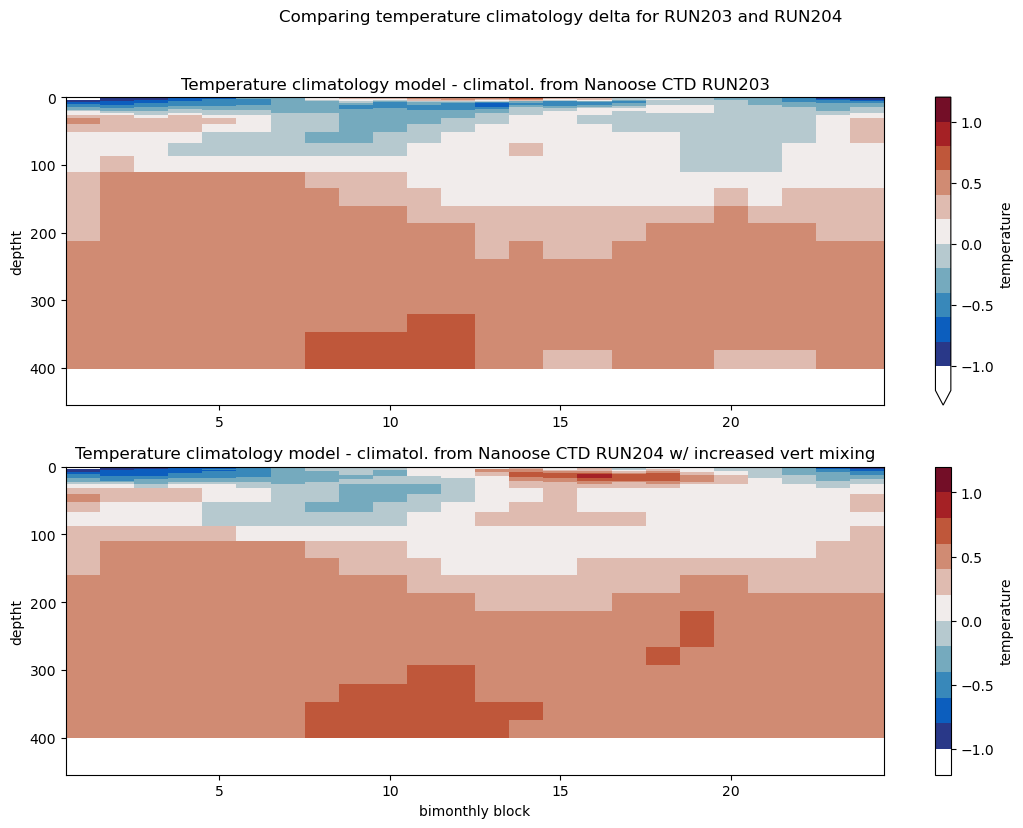

In [452]:
# model-model climatol temperature plots

fact = 1.1
fig, axs = plt.subplots(2,1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()


# temp RUN 203

# help here: 
# https://stackoverflow.com/questions/48613920/use-of-extend-in-a-pcolormesh-plot-with-discrete-colorbar
# create x boundaries to have  x- 1 intervals
boundaries = np.arange(-1.2, 1.4, 0.2)
# create list of colors from colormap
cmap_balance = plt.cm.get_cmap('cmo.balance',len(boundaries))
colors = list(cmap_balance(np.arange(len(boundaries))))
#replace first color with white
colors[0] = "white"
cmap = mpl.colors.ListedColormap(colors[:-1], "")
# set over-color to last color of list 
cmap.set_over(colors[-1])
norm = mpl.colors.BoundaryNorm(boundaries, ncolors=len(boundaries)-1, clip=False)

xr.plot.pcolormesh(RUN203_temp_clim - temp_clim, ax = axs[0], cmap = cmap, vmin=-1.2, vmax=1.2)
#xr.plot.pcolormesh(RUN203_temp_clim - temp_clim, ax = axs[0], cmap = cm.cm.balance)

# temp RUN204

boundaries = np.arange(-1.2, 1.4, 0.2)
# create list of colors from colormap
cmap_balance = plt.cm.get_cmap('cmo.balance',len(boundaries))
colors = list(cmap_balance(np.arange(len(boundaries))))
#replace first color with white
colors[0] = "white"
cmap = mpl.colors.ListedColormap(colors[:-1], "")
# set over-color to last color of list 
cmap.set_over(colors[-1])
norm = mpl.colors.BoundaryNorm(boundaries, ncolors=len(boundaries)-1, clip=False)

xr.plot.pcolormesh(RUN204_temp_clim - temp_clim, ax = axs[1], cmap = cmap, vmin=-1.2, vmax=1.2)
#xr.plot.pcolormesh(RUN204_temp_clim - temp_clim, ax = axs[1], cmap = cm.cm.balance)

axs[0].invert_yaxis()
axs[1].invert_yaxis()

axs[0].set_xlabel('')
axs[1].set_xlabel('bimonthly block')

axs[0].set_title('Temperature climatology model - climatol. from Nanoose CTD RUN203')
axs[1].set_title('Temperature climatology model - climatol. from Nanoose CTD RUN204 w/ increased vert mixing')


fig.suptitle('Comparing temperature climatology delta for RUN203 and RUN204')

Text(0.5, 0.98, 'Comparing salt climatology between RUN203 and RUN204')

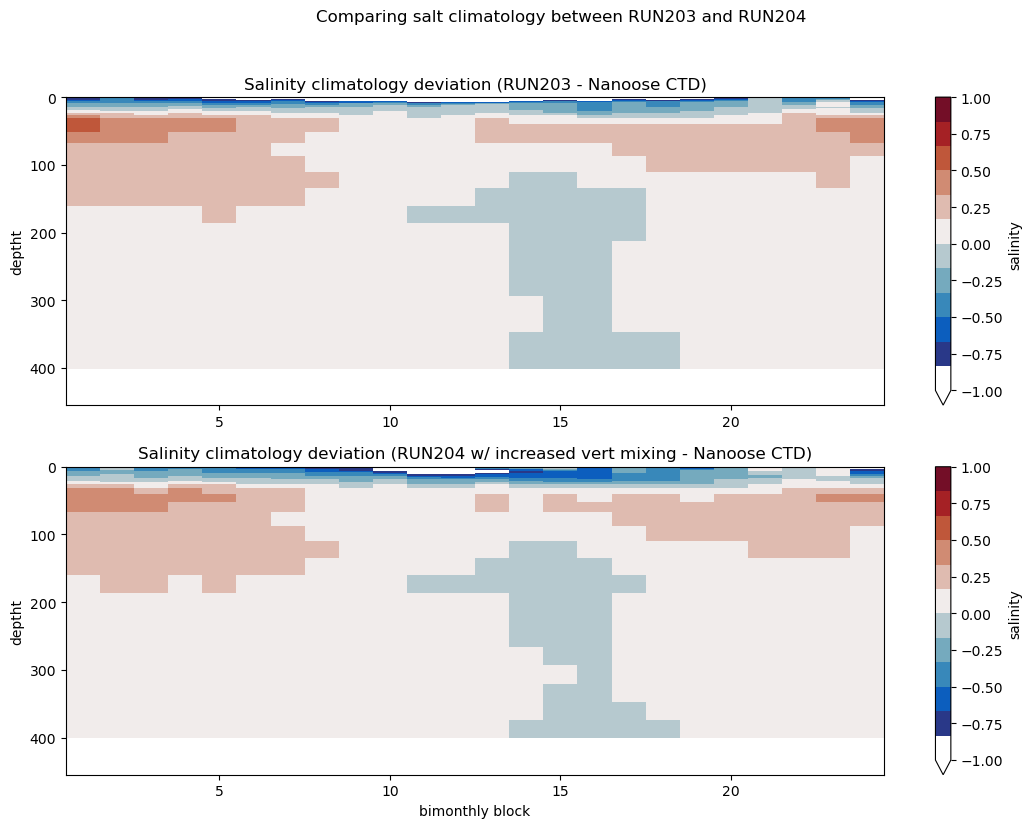

In [467]:
# model-model climatol salt plots

fact = 1.1
fig, axs = plt.subplots(2,1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

boundaries = np.arange(-1.2, 1.4, 0.2)
# create list of colors from colormap
cmap_balance = plt.cm.get_cmap('cmo.balance',len(boundaries))
colors = list(cmap_balance(np.arange(len(boundaries))))
#replace first color with white
colors[0] = "white"
cmap = mpl.colors.ListedColormap(colors[:-1], "")
# set over-color to last color of list 
cmap.set_over(colors[-1])
norm = mpl.colors.BoundaryNorm(boundaries, ncolors=len(boundaries)-1, clip=False)

# temp RUN 203
xr.plot.pcolormesh(RUN203_salt_clim - salt_clim, ax = axs[0], cmap = cmap, vmin=-1, vmax=1)

# temp RUN204
xr.plot.pcolormesh(RUN204_salt_clim - salt_clim, ax = axs[1], cmap = cmap, vmin=-1, vmax=1)

axs[0].invert_yaxis()
axs[1].invert_yaxis()

axs[0].set_xlabel('')
axs[1].set_xlabel('bimonthly block')

axs[0].set_title('Salinity climatology deviation (RUN203 - Nanoose CTD)')
axs[1].set_title('Salinity climatology deviation (RUN204 w/ increased vert mixing - Nanoose CTD)')


fig.suptitle('Comparing salt climatology between RUN203 and RUN204')

Text(0.5, 1.0, 'Temp climatology difference')

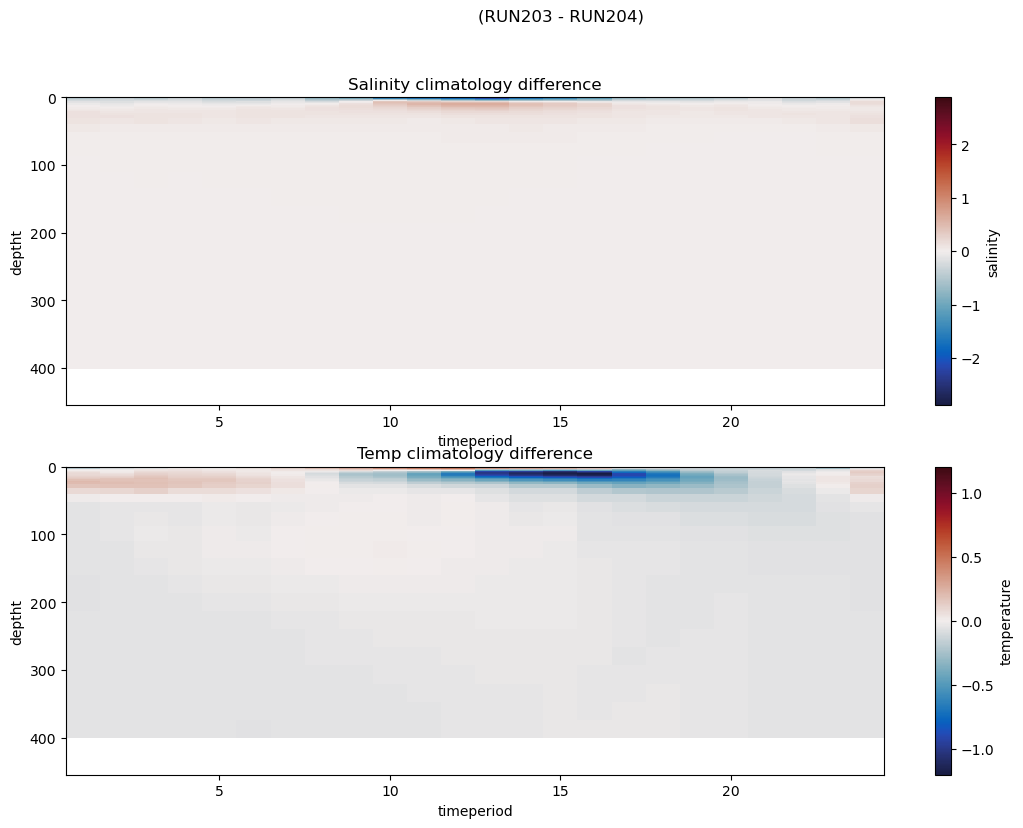

In [381]:
fact = 1.1
fig, axs = plt.subplots(2,1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
xr.plot.pcolormesh(RUN203_salt_clim - RUN204_salt_clim, ax = axs[0], cmap = cm.cm.balance)
xr.plot.pcolormesh(RUN203_temp_clim - RUN204_temp_clim, ax = axs[1], cmap = cm.cm.balance)

axs[0].invert_yaxis()
axs[1].invert_yaxis()

fig.suptitle('(RUN203 - RUN204)')

axs[0].set_title("Salinity climatology difference")
axs[1].set_title("Temp climatology difference")

Text(0.5, 0.98, '')

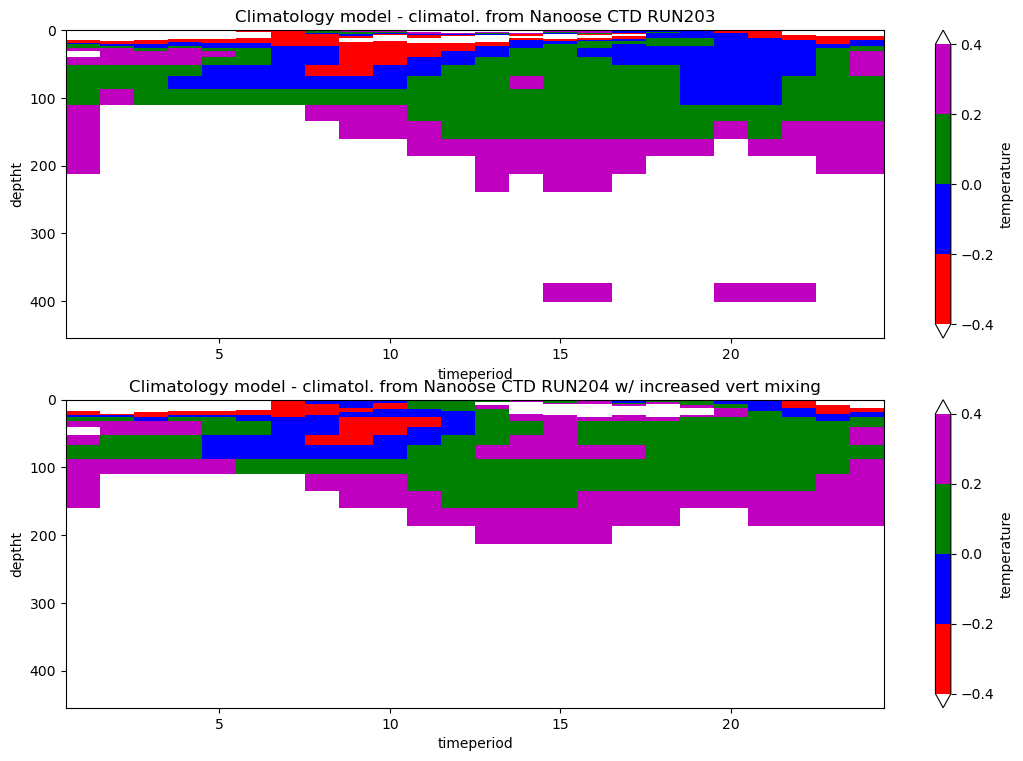

In [380]:


fact = 1.1
fig, axs = plt.subplots(2,1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

# bins
thresh_t = 0.2
bins= [thresh_t * -1 * 2, thresh_t * -1, 0, thresh_t, thresh_t * 2]

# temp RUN 203
cmap, norm = from_levels_and_colors(bins, ['r','b', 'g','m'])
xr.plot.pcolormesh(RUN203_temp_clim - temp_clim, ax = axs[0], cmap = cmap, norm=norm)
#xr.plot.pcolormesh(RUN203_temp_clim - temp_clim, ax = axs[0], cmap = cm.cm.balance)

# temp RUN204
xr.plot.pcolormesh(RUN204_temp_clim - temp_clim, ax = axs[1], cmap = cmap, norm=norm)
#xr.plot.pcolormesh(RUN204_temp_clim - temp_clim, ax = axs[1], cmap = cm.cm.balance)

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[0].set_title('Climatology model - climatol. from Nanoose CTD RUN203')
axs[1].set_title('Climatology model - climatol. from Nanoose CTD RUN204 w/ increased vert mixing')


fig.suptitle('')